# **OpenPyTEA** Walkthrough

## 🧭 Overview

This walkthrough demonstrates the full workflow of **OpenPyTEA**, an open-source Python toolkit for transparent and reproducible **techno-economic assessment (TEA)** of chemical and energy systems.

In this notebook, you will learn how to:
1. Define process equipment and estimate their purchased and direct (installed) costs.
2. Assemble a plant configuration and calculate capital and operating expenditures.
3. Evaluate economic performance metrics such as **NPV**, **IRR**, **payback time**, and **levelized cost (LCOP)**.
4. Visualize **cost breakdowns** of equipment costs, fixed capital, as well as variable and fixed OPEX
5. Perform **sensitivity** and **uncertainty analyses** using tornado and Monte Carlo plots.

This walkthrough is intended for both researchers and students, providing a practical, hands-on introduction to techno-economic modeling directly in Python.

## ⚙️ Setup & Imports

Before getting started, make sure that **OpenPyTEA** is installed. You can install it with:

In [1]:
# pip install git+https://github.com/pbtamarona/OpenPyTEA

Import the main modules used throughout this walkthrough:

In [2]:
# Core modules
from openpytea.equipment import *
from openpytea.plant import *
from openpytea.analysis import *

The following modules will be used:

| Module      | Description                                                             |
|-------------|-------------------------------------------------------------------------|
| `equipment` | Defines individual process units and calculates equipment costs.        |
| `plant`     | Combines equipment objects into a full plant configuration for TEA.     |
| `analysis`  | Provides tools for plotting, sensitivity analysis, and uncertainty analysis. |

Once the imports complete successfully, you’re ready to define your process equipment.

## 🧱 Define Equipment

Each process unit (e.g., compressor, heat exchanger, reactor) is represented by an `Equipment` object.  
You can specify the **category*, **type**, **material**, and optionally provide custom cost data or scaling factors.

The equipment module automatically:
1. Selects the appropriate cost correlation from `data/cost_correlations.csv` based on the equipment `category` and `type`.  
2. Estimates the purchased and direct costs.  
3. Adjusts costs for inflation using CEPCI data to the 2023 cost year.  
4. Stores all technical and economic attributes for plant-level aggregation.  
5. If the equipment type is not found in the database, the user must specify its `purchase_cost`.

The direct costs refer to those incurred during the construction of a plant (installed costs), in addition to the purchased (delivered) cost of equipment, such as:
- Equipment erection, including foundations and minor structural work  
- Piping, including insulation and painting  
- Electrical, power, and lighting systems  
- Instruments and automatic process control (APC) systems  
- Process buildings and structures  
- Ancillary buildings, offices, laboratory buildings, and workshops (if not costed separately as offsites)  
- Storage for raw materials and finished products (if not costed separately as offsites)  
- Utilities and plant provision for steam, water, air, and firefighting services (if not costed separately as offsites)  
- Site preparation  

Here are the mandatory and optional input for `Equipment` objects: 

| **Input Parameter**          | **Description**                                                                                                                                                                                              | **Example**                                               |
|-----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------|
| `name`                      | User-defined name or label for the equipment instance.                                                                                                                                                         | `"Reactor R-101"`, `"Pump P-201"`                         |
| `param`                     | Primary sizing or design variable used in cost correlations (e.g., volume, area, flow rate). Units depend on the equipment type (see `data/cost_correlations.csv`).                                            | `50` (m³), `800` (m²), `5000` (kW)                        |
| `process_type`              | Type of process handled by the equipment, which determines installation and auxiliary cost factors. Must be one of `"Solids"`, `"Fluids"`, `"Mixed"`, or `"Electrical"`.                                        | `"Fluids"`                                                |
| `category`                  | Equipment category. Must match the `category` field (if available) in `data/cost_correlations.csv` to use the corresponding cost correlation.                                                                  | `"Pump"`, `"Heat Exchanger"`, `"Compressor"`, `"Reactor"` |
| `type` *(optional)*         | Equipment subtype. Must match the `type` field (if available) in `data/cost_correlations.csv` to use the corresponding cost correlation.                                                                        | `"Centrifugal"`, `"Shell-and-tube"`                       |
| `material` *(optional)*     | Material of construction. Affects installed cost via material multipliers. Defaults to `"Carbon steel"`.                                                                                                       | `"316 stainless steel"`, `"Aluminum"`, `"Monel"`          |
| `num_units` *(optional)*    | Number of identical units. Automatically increased if the required capacity exceeds the correlation’s valid range.                                                                                             | `2`                                                       |
| `purchase_cost` *(optional)*| Manually override the calculated purchase cost. If provided, the correlation and `param` are ignored.                                                                                                           | `1.5e6`                                                   |
| `cost_func` *(optional)*    | Explicitly specify a correlation key from `data/cost_correlations.csv`, overriding automatic category/type matching.                                                                                            | `"HX_shell_tube_01"`                                      |
| `target_year` *(optional)*  | Target year for inflation adjustment via CEPCI. Defaults to `2023`.                                                                                                                                            | `2025`                                                    |

Multiple equipment objects can be defined and later combined into a complete process plant using the `Plant` class (next section).

### Equipment Class – Usage Examples

Below are practical examples demonstrating all key functionalities of the `Equipment` class.

**1. Automatic Correlation Lookup**

Uses `category` and `type` to fetch cost correlations automatically and apply CEPCI inflation.

In [3]:
hx = Equipment(
    name="HX-101",
    param=900,                      # e.g., m² area
    process_type="Fluids",
    category="Heat Exchangers",
    type="U-tube shell & tube",
    material="316 stainless steel"
)

print(hx)

# To fetch the purchase and direct installation costs you can use:
print(hx.purchased_cost)
print(hx.direct_cost)

Name=HX-101, Category=Heat Exchangers, Sub-type=U-tube shell & tube, Material=316 stainless steel, Process Type=Fluids, Parameter=900, Number of units=1, Purchased Cost=316141.10962497495, Direct Cost=1182367.7499974065)
316141.10962497495
1182367.7499974065


**2. Using an Explicit `cost_func` Key**

Bypass automatic lookup and use a known cost-correlation key directly.

In [4]:
comp1 = Equipment(
    name='Comp-1', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=1, # MW
    category='Compressors & Blowers', 
    type='Compressor, centrifugal',
    cost_func = 'co2_compressor_manzolini_2011'
)

print(comp1)

Name=Comp-1, Category=Compressors & Blowers, Sub-type=Compressor, centrifugal, Material=Carbon steel, Process Type=Fluids, Parameter=1, Number of units=1, Purchased Cost=3391131.8465951304, Direct Cost=10851621.909104418)


**3. Manually Defined `purchased_cost`**

Skip correlation and inflation calculations by supplying your own purchased cost and cost year (optional).

In [5]:
dryer = Equipment(
    name="Rotary Dryer D-301",
    param=0,                        # ignored
    process_type="Solids",
    category="Dryer",
    material="Carbon steel",
    purchased_cost=1_500_000,        # already in target-year money
    cost_year=2021,
)
print(dryer)

Name=Rotary Dryer D-301, Category=Dryer, Sub-type=None, Material=Carbon steel, Process Type=Solids, Parameter=None, Number of units=1, Purchased Cost=1694695.2595936793, Direct Cost=4236738.148984198)


**4. Auto-Parallelization for Oversized Equipment**

If `param` exceeds the upper bound in the correlation, the system automatically creates multiple parallel units.

In [6]:
comp2 = Equipment(
    name="Air Compressor",
    param=50_000,                   # exceeds upper_parallel → auto-splits
    process_type="Fluids",
    category='Compressors & Blowers', 
    type='Compressor, centrifugal',
)
print(comp2)
print(comp2.num_units)

Name=Air Compressor, Category=Compressors & Blowers, Sub-type=Compressor, centrifugal, Material=Carbon steel, Process Type=Fluids, Parameter=50000, Number of units=2, Purchased Cost=27000119.50208918, Direct Cost=86400382.40668538)
2


 **5. Inflation Adjustment to a Custom Year**

Calculate cost for a different inflation-adjusted year using CEPCI.

In [7]:
hx_2020 = Equipment(
    name="HX E-102",
    param=850,
    process_type="Fluids",
    category="Heat Exchangers",
    type="U-tube shell & tube",
    material="316 stainless steel",
    target_year=2020
)
print(hx_2020)

Name=HX E-102, Category=Heat Exchangers, Sub-type=U-tube shell & tube, Material=316 stainless steel, Process Type=Fluids, Parameter=850, Number of units=1, Purchased Cost=221775.1706670056, Direct Cost=829439.138294601)


**6. Effect of Material and Process Type on Direct Cost**

Demonstrates how material and process factors modify the direct (installed) cost.

In [8]:
mixer_cs = Equipment(
    name="Agitator M-101 (CS)",
    param=100,
    process_type="Fluids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Carbon steel"
)
print(mixer_cs)

mixer_alloy = Equipment(
    name="Agitator M-102 (Alloy)",
    param=10,
    process_type="Fluids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Hastelloy C"
)
print(mixer_alloy)

mixer_solids = Equipment(
    name="Agitator M-101 (Mixed)",
    param=100,
    process_type="Solids",
    category="Agitators & mixers",
    type="Propeller mixer",
    material="Carbon steel"
)
print(mixer_solids)

Name=Agitator M-101 (CS), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Carbon steel, Process Type=Fluids, Parameter=100, Number of units=2, Purchased Cost=249214.4300170991, Direct Cost=797486.1760547172)
Name=Agitator M-102 (Alloy), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Hastelloy C, Process Type=Fluids, Parameter=10, Number of units=1, Purchased Cost=43149.5821962902, Direct Cost=180796.74940245596)
Name=Agitator M-101 (Mixed), Category=Agitators & mixers, Sub-type=Propeller mixer, Material=Carbon steel, Process Type=Solids, Parameter=100, Number of units=2, Purchased Cost=249214.4300170991, Direct Cost=623036.0750427478)


Here are some of the available material options and their corresponding installation cost multipliers:
- **Carbon steel** — 1.00  
- **Aluminum** — 1.07  
- **Bronze** — 1.07  
- **Cast steel** — 1.10  
- **304 stainless steel** — 1.30  
- **316 stainless steel** — 1.30  
- **321 stainless steel** — 1.50  
- **Hastelloy C** — 1.55  
- **Monel** — 1.65  
- **Nickel** — 1.70  
- **Inconel** — 1.70  

**7. Forcing a Specific Number of Units**

Override the automatically calculated number of parallel units.

In [9]:
fridge = Equipment(
    name="Refrigerator R-201",
    param=180,
    process_type="Fluids",
    category="Utilities",
    type="Packaged mechanical refrigerator",
    num_units=3                    # manually fix number of units
)
print(fridge)

Name=Refrigerator R-201, Category=Utilities, Sub-type=Packaged mechanical refrigerator, Material=Carbon steel, Process Type=Fluids, Parameter=180, Number of units=3, Purchased Cost=579826.6516813494, Direct Cost=1855445.285380318)


## 🏭 Creating the Plant

`Plant` aggregates equipment and economics to estimate:
- **ISBL / OSBL / D&E / Contingency** → fixed capital using process-type multipliers and an optional capital factor `fc`.
- **Location-adjusted costs** via country/region location factors.    
- **Variable OPEX** from itemized consumptions and prices (`variable_opex_inputs`). 
- **Fixed OPEX** (labor, supervision, overheads, maintenance, taxes/insurance, etc.) with an optional OPEX factor `fp`, including automatic **working-capital** estimation when not supplied.
- **Operating labor costs** from an internal labor model that counts operators (when not provided) from the equipment composition (solids/fluids/mixed).  
- **Revenues** for a main product and optional by- or co-products, with built-in production ramp-up in the early years.  
- **Cash flow, NPV, LCOP, payback, ROI, IRR** over the project lifetime, using your utilization, tax rate, depreciation model, and discount rate(s), with support for multi-scenario arrays.

Together, this makes `Plant` a self-contained TEA engine that turns your equipment list and economic assumptions into a full cash-flow and performance profile.

### Configurating a plant

In [10]:
config = {
    "plant_name": "Demo Plant",                 # The name of your plant. This will be used in plots
    # Basic plant information
    "process_type": "Fluids",                   # "Solids" | "Fluids" | "Mixed"
    "country": "United States",                 # Scroll down for country options. Optional, defaults to "United States"
    "region": "Gulf Coast",                     # Scroll down for region options. Optional, defaults to "Gulf Coast"
    "equipment": [hx, comp1, comp2],            # List of Equipment (each has .direct_cost)
    "interest_rate": 0.09,                      # Discount/interest rate. Optional, defaults to 0.09
    "project_lifetime": 30,                     # In years (needs to be int ≥ 3). Optional, defaults to 20
    "plant_utilization": 0.90,                  # 0-1. Optional, defaults to 1
    "tax_rate": 0.25,                           # 0-1, not used in levelized cost calculations. Optional, defaults to 0
    
    # Operator labor details
    'operator_hourly_rate': {
              'rate': 35,                       # This is in $/hour. Optional, defaults to  $38.11/hour 
              },
    'operators_per_shift': None,                # Optional, system will estimate based on process steps if None
    'operators_hired': None,                    # Optional, system will estimate based on operators_per_shift if None
    'working_weeks_per_year': 46,               # This is the number of weeks the operator works. Optional, defaults to 49
    'working_shifts_per_week': 5,               # This is the number of shifts the operator works per week. Optional, defaults to 5

    # Plant products information
    'plant_products': {                         # Here we define the products produced by the plant
              'methanol': {                     # The first entry will be the main product. Important for levelized cost calculations.
                  'production': 125_000,        # Daily production in units/day
                  'price': 2.5                  # Price in USD/unit. No need to be specified for levelized cost calculations.
              },
              'hydrogen': {                    # Second and subsequent products are by- or co-products (if any)
                  'production': 100_000,        # Daily production in units/day
                  'price': 2.0                  # Price in USD/unit
              }
            },

    # Plant variable operating expenses, such as utilities and raw materials
    "variable_opex_inputs": {                   # Here, we define variable operating expenses that recur annually
        "electricity":   {"consumption": 2.2e6, # Daily consumption in units/day
                          "price": 0.08},       # Price in USD/unit
        "cooling_water": {"consumption": 1.6e6, "price": 0.0007},
    },

    # Additional CAPEX and OPEX information
    "working_capital": None,                    # in USD. Optional, defaults to 15% of fixed capital
    'additional_capex_cost': [500_000, 200_000],# List of additional CAPEX occuring during the project. For example, equipment replacements.
    'additional_capex_years': [8, 15],          # List of years in which additional CAPEX costs occur
    'fc': None,                                 # Positive float, as a multiple of total equipment direct cost. Optional, defaults to 1.
    'fp': None,                                 # Positive float, as a multiple of fixed production costs. Optional, defaults to 1.

    # Depreciation (optional; defaults to straight-line if omitted). Scroll down for more details.
    "depreciation": {
        "method": "macrs",            # "straight_line" | "declining_balance" | "macrs"
        "macrs_class": 7,             # 3,5,7,10,15,20 (half-year convention)
        "service_start_year": 2       # first operating year in your ramp (0/0/40%/80%/100%)
    }
}

demo_plant = Plant(config)

print(demo_plant)

ProcessPlant Configuration
----------------------------------------
Plant Name:                 Demo Plant
Process Type:               Fluids
Country / Region:           United States / Gulf Coast
Interest Rate:              0.09
Project Lifetime (years):   30
Plant Utilization:          0.9
Tax Rate:                   0.25
Working Capital:            None
Depreciation Settings:      {
    "method": "macrs",
    "macrs_class": 7,
    "service_start_year": 2
}

Operator Labor Inputs
  Hourly Rate:              {
    "rate": 35
}
  Operators per Shift:      None
  Operators Hired:          None
  Working Weeks / Year:     46
  Working Shifts / Week:    5
  Operating Shifts / Day:   3

Products
{
    "methanol": {
        "production": 125000,
        "price": 2.5
    },
    "hydrogen": {
        "production": 100000,
        "price": 2.0
    }
}

Variable OPEX Inputs:
{
    "electricity": {
        "consumption": 2200000.0,
        "price": 0.08
    },
    "cooling_water": {
        "con

Update any setting later without **rebuilding the plant** using:

In [11]:
config = {
    'project_lifetime': 20,
    'interest_rate': 0.08,
    'variable_opex_inputs': {
        'cooling_water': {"consumption": 0.8e6, "price": 0.0007},
        "steam": {"consumption": 4.0e5, "price": 0.02},
    }
}

demo_plant.update_configuration(config)
print(demo_plant)

ProcessPlant Configuration
----------------------------------------
Plant Name:                 Demo Plant
Process Type:               Fluids
Country / Region:           United States / Gulf Coast
Interest Rate:              0.08
Project Lifetime (years):   20
Plant Utilization:          0.9
Tax Rate:                   0.25
Working Capital:            None
Depreciation Settings:      {
    "method": "macrs",
    "macrs_class": 7,
    "service_start_year": 2
}

Operator Labor Inputs
  Hourly Rate:              {
    "rate": 35
}
  Operators per Shift:      None
  Operators Hired:          None
  Working Weeks / Year:     46
  Working Shifts / Week:    5
  Operating Shifts / Day:   3

Products
{
    "methanol": {
        "production": 125000,
        "price": 2.5
    },
    "hydrogen": {
        "production": 100000,
        "price": 2.0
    }
}

Variable OPEX Inputs:
{
    "electricity": {
        "consumption": 2200000.0,
        "price": 0.08
    },
    "cooling_water": {
        "con

Nested dictionaries (e.g., `variable_opex_inputs`, `plant_products`, `operator_hourly_rate`) are merged recursively, so unspecified sub-keys are preserved rather than overwritten.

### Summary of The Configuration Keys (Plant Object)

| **Key**                           | **Type / Allowed Values**                             | **Description**                                                                                                                 |
| --------------------------------- | ----------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| `plant_name`                      | `str`                                                 | Name used in plots.                                                                                                             |
| `process_type`                    | `"Solids", "Fluids", "Mixed"`                   | Determines cost factors for OSBL, D&E, and contingency.                                                                         |
| `country`, `region`               | `str`                                                 | Used for location cost factors. `region` required when country has regional factors. Scroll down for options                    |
| `equipment`                       | `list[Equipment]`                                     | List of equipment objects. Each must expose `.direct_cost`, either computed or user-given.                                      |
| `interest_rate`                   | `float`                                               | Discount rate used for NPV, capital recovery, and working-capital interest. Default: 0.09.                                      |
| `project_lifetime`                | `int ≥ 3`                                             | Economic analysis horizon in years. Needs to be more that 3 years Default: 20 years.                                            |
| `plant_utilization`               | `0–1 float`                                           | Fraction of the year operating. Affects annual production and OPEX. Default: 1.                                                 |
| `tax_rate`                        | `0–1 float`                                           | Applied to net income for annual tax calculations (not used in levelized cost). Default: 0.                                     |
| **Operator labor settings**       |                                                       |                                                                                                                                 |
| `operator_hourly_rate`            | `{ "rate": float }`                                   | Operator labor cost model. If omitted, a default hourly rate is used.                                                           |
| `operators_per_shift`             | `int` or `None`                                       | If `None`, the system estimates the number based on process steps/equipment.                                                    |
| `operators_hired`                 | `int` or `None`                                       | If `None`, computed from `operators_per_shift` and shift schedule.                                                              |
| `working_weeks_per_year`          | `int`                                                 | Used to convert hourly rate → annual labor cost. Default: 49.                                                                   |
| `working_shifts_per_week`         | `int`                                                 | Number of shifts per week the operators work. Default: 5.                                                                       |
| **Products and revenues**         |                                                       |                                                                                                                                 |
| `product_inputs`                  | `dict` of `{product: {production, price}}`            | First product = **main product** for levelized cost. `production` is **daily units**, automatically annualized via utilization. |
| **Variable operating expenses**   |                                                       |                                                                                                                                 |
| `variable_opex_inputs`            | `{item: {consumption, price}}`                        | Daily consumption and unit price. Annualized in OPEX calculations.                                                              |
| **Capital costs**                 |                                                       |                                                                                                                                 |
| `working_capital`                 | `float` or `None`                                     | If `None`, defaults to **15% of fixed capital**.                                                                                |
| `additional_capex_cost`           | `list[float]`                                         | Lump-sum CAPEX events (e.g., equipment replacements).                                                                           |
| `additional_capex_years`          | `list[int]`                                           | Year corresponding to each entry in `additional_capex_cost`.                                                                    |
| `fc`                              | `float` or `None`                                     | Multiplier on equipment **direct cost** to compute installed cost. Defaults to 1 if omitted.                                    |
| `fp`                              | `float` or `None`                                     | Multiplier on **fixed production costs**. Defaults to 1 if omitted.                                                             |
| **Depreciation settings**         |                                                       |                                                                                                                                 |
| `depreciation`                    | `dict` or `None`                                      | Optional depreciation configuration block. If omitted, default **straight-line** depreciation is applied.                       |
| `depreciation.method`             | `"straight_line"` / `"declining_balance"` / `"macrs"` | Depreciation model to use. Defaults to `"straight_line"` if not provided.                                                       |
| `depreciation.life`               | `int`                                                 | Asset service life in years. Used for straight-line and declining-balance methods.                                              |
| `depreciation.salvage_fraction`   | `float` (0–1)                                         | Fraction of value remaining at end of life (not depreciated). Default: `0.0`. Applies to straight-line and declining-balance    |
| `depreciation.db_factor`          | `float`                                               | Declining-balance factor, e.g., `2.0` for 200% DDB or `1.5` for 150% DB. Auto-switches to straight-line when advantageous.      |
| `depreciation.macrs_class`        | `int` ∈ {3, 5, 7, 10, 15, 20}                         | MACRS recovery period (years). Determines the predefined IRS depreciation schedule (half-year convention).                      |
| `depreciation.convention`         | `"half_year"` *(default)*                             | Depreciation timing convention for MACRS. Only `"half_year"` is currently implemented.                                          |
| `depreciation.service_start_year` | `int ≥ 0`                                             | Year (relative to start-up) when depreciation begins. Common choice: **2** (first full operating year). Applies to all methods. |

### How things are computed and how to print out the results


#### **1. Fixed Capital Investment**

The total fixed capital investment (FCI) of the plant consists of:
- Inside Battery Limits (ISBL)  
- Outside Battery Limits (OSBL)  
- Design and engineering costs (D&E)
- Contingency

Estimated using the following equation:
$$
\text{FCI} = \text{ISBL} \cdot (1 + OS) \cdot (1 + D\&E + X) \cdot LF
$$
<p style="text-align: justify;">Where, ISBL is the total of equipment direct costs and the other are factors are determined based on the user inputs in the plant configuration: <code>process_type</code>, <code>country</code>, and <code>region</code>.</p>

- **Process type**: Determines the nature of the plant's operation and influences cost estimation factors. The available types are:  
    - `Solids`: OS = 0.4, D\&E = 0.2, X = 0.1  
    - `Fluids`: OS = 0.3, D\&E = 0.3, X = 0.1  
    - `Mixed`: OS = 0.4, D\&E = 0.25, X = 0.1  

- **Country & region**: Determines the location factor (_LF_), which adjusts the estimated capital cost to reflect local economic conditions and construction costs. Available countries and regions are:  

    - **United States**
        - Gulf Coast: 1.00  
        - East Coast: 1.04  
        - West Coast: 1.07  
        - Midwest: 1.02  
    - **Canada** 
        - Ontario: 1.00  
        - Fort McMurray: 1.60  
    - **Mexico**: 1.03  
    - **Brazil**: 1.14  
    - **China**  
        - Imported: 1.12  
        - Indigenous: 0.61  
    - **Japan**: 1.26  
    - **Southeast Asia**: 1.12  
    - **Australia**: 1.21  
    - **India**: 1.02  
    - **Middle East**: 1.07  
    - **France**: 1.13  
    - **Germany**: 1.11  
    - **Italy**: 1.14  
    - **Netherlands**: 1.19  
    - **Russia**: 1.53  
    - **United Kingdom**: 1.02  

*Note: These factors are based on _Chemical Engineering Design_, 3rd Edition (Towler & Sinnott, 2021).*

Call to calculate FCI:

In [12]:
demo_plant.calculate_fixed_capital(print_results=True)


Capital cost estimation
ISBL: $98,434,372.07
OSBL: $29,530,311.62
Design and engineering: $38,389,405.11
Contingency: $12,796,468.37
Fixed capital investment: $179,150,557.16


If you need only the ISBL, you can just perform `calculate_isbl`:

In [13]:
demo_plant.calculate_isbl(print_results=True)

ISBL cost estimation
  - HX-101: $1,182,367.75
  - Comp-1: $10,851,621.91
  - Air Compressor: $86,400,382.41
Total ISBL: $98,434,372.07


To retrieve the values of cost estimates for each component of capital cost, you can simply access the corresponding attributes:

In [14]:
print(f"OSBL: ${demo_plant.osbl:,.2f}")
print(f'Design and Engineering: ${demo_plant.dne:,.2f}')
#  ... and so on

OSBL: $29,530,311.62
Design and Engineering: $38,389,405.11


#### **2. Fixed Operating Expenditure**

Fixed production costs are those costs that do not vary with the rate of production, these include:
- Maintenance
- Taxes and insurance
- Operating labor
- Supervision and overhead
- et cetera.

<p style="text-align: justify;">Fixed production costs are calculated using the <code>calculate_fixed_opex</code> function of the <code>Plant</code> object. Most cost components are derived from multiplication factors reported in <i>Analysis, Synthesis, and Design of Chemical Processes</i>, 5th Edition (Turton et al., 2018). These factors are applied to estimate fixed cost components based on the plant’s fixed capital investment, working capital, variable production costs, interest rate, and operator hourly rate.

The operator hourly rate entry follows the format:
```python
"operator_hourly_rate": {
    "rate": <hourly_rate>
    },
    ...
}

Call to calculate Fixed OPEX:

In [15]:
demo_plant.calculate_fixed_opex(print_results=True)  # Calculate fixed OPEX costs

Fixed production costs estimation
Operating labor costs: $837,200.00 per year
Supervision costs: $209,300.00 per year
Direct salary overhead: $523,250.00 per year
Laboratory charges: $83,720.00 per year
Maintenance costs: $4,921,718.60 per year
Taxes and insurance costs: $1,476,515.58 per year
Rent of land costs: $1,919,470.26 per year
Environmental charges: $1,279,646.84 per year
Operating supplies: $885,909.35 per year
General plant overhead: $1,020,337.50 per year
Interest on working capital: $2,149,806.69 per year
Patents and royalties: $1,633,007.20 per year
Distribution and selling costs: $1,633,007.20 per year
R&D costs: $2,449,510.80 per year
Fixed OPEX: $21,022,400.01 per year


To retrieve the values for each fixed operating cost components, you can do:

In [16]:
print(f'Operating labor costs: ${demo_plant.operating_labor_costs:,.2f}')
print(f'Supervision costs: ${demo_plant.supervision_costs:,.2f}')
print(f'Maintenance costs: ${demo_plant.maintenance_costs:,.2f}')
# ..... and so on

Operating labor costs: $837,200.00
Supervision costs: $209,300.00
Maintenance costs: $4,921,718.60


#### **3. Variable Operating Expenditure**

Variable operating expenses represent consumables and utilities that scale directly with plant production.
These are defined through the `variable_opex_inputs` dictionary in your plant configuration and are automatically processed inside `calculate_variable_opex()`.

Each entry in `variable_opex_inputs` follows the format:
```python
"variable_opex_inputs": {
    "<item_name>": {
        "consumption": <annual_quantity>,
        "price": <unit_price>
    },
    ...
}
```

During calculation:
1. Each item’s annual cost is computed as:

            cost = daily_consumption × price × 365 x plant_utilization

2. All items are summed to form the total variable operating cost (`self.variable_production_costs`).

3. The results are stored in the plant instance and can be printed when `print_results=True.`

For example:

In [17]:
config = {
    "variable_opex_inputs": {
        "electricity":   {"consumption": 1.1e6, "price": 0.075},
        "cooling_water": {"consumption": 1.6e6, "price": 0.0007},
        "steam":         {"consumption": 4.0e5, "price": 0.02},
        "natural_gas":   {"consumption": 1.0e5, "price": 0.035}
    },
}

demo_plant.update_configuration(config)

Then run:

In [18]:
demo_plant.calculate_variable_opex(print_results=True)

Variable production costs estimation
  - Electricity: $27,101,250.00 per year
  - Cooling water: $367,920.00 per year
  - Steam: $2,628,000.00 per year
  - Natural gas: $1,149,750.00 per year
Total Variable OPEX: $31,246,920.00 per year


#### **4. Revenue Calculation**

Plant revenue is computed from the products defined in the `plant_products` dictionary inside your configuration.
The first product listed is treated as the main product for levelized cost calculations, but all products contribute to total annual revenue.

Each product entry follows this structure:
```python
"plant_products": {
    "<main_product_name>": {
        "production": <daily_production_rate>,
        "price": <unit_price>
    },
    "<side_product_name>": {
        "production": <daily_production_rate>,
        "price": <unit_price>
    },
    ...
}
```

During processing, each product's annual revenue is computed as:

            annual_revenue = daily_production × price × 365 × plant_utilization
Then:
1. Each product’s annual revenue is calculated individually.
2. All product revenues are summed to produce the plant’s total annual revenue.
3. Results are stored on the plant instance (e.g., self.revenue_breakdown, self.total_revenue) and appear in output tables when print_results=True.

For example:

In [19]:
config = {
    "plant_products": {
        "methanol": {"production": 100_000, "price": 1.75},
        "hydrogen": {"production": 75_000, "price": 1.25}
    },
}

demo_plant.update_configuration(config)

Then you can run:

In [20]:
demo_plant.calculate_revenue(print_results=True)

Revenue estimation
  - Methanol: $57,487,500.00 per year
  - Hydrogen: $30,796,875.00 per year
Total Revenue: $88,284,375.00 per year


#### **5. Cash Flow Calculation**

The cash flow represents the net annual financial performance of the plant, combining revenues, operating costs, capital investments, taxes, and depreciation.
It is generated by calling:

In [21]:
demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$53,745,167.15",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-72,556,091.03"
1,2,"$107,490,334.30",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-126,301,258.18"
2,3,"$44,787,639.29","$35,313,750.00","$31,309,691.88","$4,004,058.12","$25,600,614.62","$-21,596,556.50",$0.00,"$-40,783,581.17"
3,4,$0.00,"$70,627,500.00","$43,808,459.88","$26,819,040.12","$43,873,971.45","$-17,054,931.33",$0.00,"$26,819,040.12"
4,5,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$31,333,432.45","$6,893,098.67",$0.00,"$38,226,531.12"
5,6,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$22,375,904.59","$15,850,626.53","$1,723,274.67","$36,503,256.45"
6,7,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$15,998,144.75","$22,228,386.36","$3,962,656.63","$34,263,874.49"
7,8,"$500,000.00","$88,284,375.00","$50,057,843.88","$38,226,531.12","$15,980,229.70","$22,246,301.42","$5,557,096.59","$32,169,434.53"
8,9,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$15,998,144.75","$22,228,386.36","$5,561,575.35","$32,664,955.76"
9,10,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$7,990,114.85","$30,236,416.27","$5,557,096.59","$32,669,434.53"


The method builds yearly arrays for capital cost, production, revenue, OPEX, depreciation, taxable income, and cash flow over the defined project lifetime.

---
**Capital Expenditure (CAPEX) Ramp**

Capital spending occurs during the first three years according to:

| **Year**   | **CAPEX Fraction** | **Description**                              |
| ---------- | ------------------ | -------------------------------------------- |
| 0          | 30%                | Initial design and early construction        |
| 1          | 60%                | Major equipment procurement and installation |
| 2          | 10%                | Commissioning and start-up costs             |
| Final year | —                  | Working capital released (negative CAPEX)    |

Working capital is drawn in year 2 and returned in the final year.

---
**Production Ramp: effects the revenue and operating costs**

Plant output increases gradually to reach full capacity:

| **Year** | **Production Level** |
| -------- | -------------------- |
| 0        | 0%                   |
| 1        | 0%                   |
| 2        | 40%                  |
| 3        | 80%                  |
| 4+       | 100% (steady state)  |

Full annual production is calculated as:

            Annual Production = daily_prod × 365 × plant_utilization × ramp_factor

The revenue and operating costs for each year also follows the production ramp. The CAPEX and Production Ramp are currently not modifiable.

---
**Depreciation**

Depreciation is applied using the selected depreciation method
(`straight_line`, `declining_balance`, or `macrs`) and begins in the configured `service_start_year`.

You can change the depreciation method as follows: 

In [22]:
# Switching to straight-line depreciation
demo_plant.update_configuration({
    "depreciation": {
        "method": "straight_line",
        "life": 12,
        "salvage_fraction": 0.05,
        "service_start_year": 2
    }
})

demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$53,745,167.15",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-72,556,091.03"
1,2,"$107,490,334.30",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-126,301,258.18"
2,3,"$44,787,639.29","$35,313,750.00","$31,309,691.88","$4,004,058.12","$14,182,752.44","$-10,178,694.32",$0.00,"$-40,783,581.17"
3,4,$0.00,"$70,627,500.00","$43,808,459.88","$26,819,040.12","$14,182,752.44","$12,636,287.68",$0.00,"$26,819,040.12"
4,5,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$3,159,071.92","$35,067,459.20"
5,6,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$6,010,944.67","$32,215,586.45"
6,7,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$6,010,944.67","$32,215,586.45"
7,8,"$500,000.00","$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$6,010,944.67","$31,715,586.45"
8,9,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$6,010,944.67","$32,215,586.45"
9,10,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,182,752.44","$24,043,778.68","$6,010,944.67","$32,215,586.45"


In [23]:
# Switching to Declining-Balance (200% DDB)
demo_plant.update_configuration({
    "depreciation": {
        "method": "declining_balance",
        "life": 10,
        "db_factor": 2.0,        # 200% DDB (use 1.5 for 150% DB)
        "salvage_fraction": 0.1,
        "service_start_year": 2
    }
})

demo_plant.calculate_cash_flow(print_results=True)

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$53,745,167.15",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-72,556,091.03"
1,2,"$107,490,334.30",$0.00,"$18,810,923.88","$-18,810,923.88",$0.00,"$-18,810,923.88",$0.00,"$-126,301,258.18"
2,3,"$44,787,639.29","$35,313,750.00","$31,309,691.88","$4,004,058.12","$35,830,111.43","$-31,826,053.31",$0.00,"$-40,783,581.17"
3,4,$0.00,"$70,627,500.00","$43,808,459.88","$26,819,040.12","$28,664,089.15","$-1,845,049.03",$0.00,"$26,819,040.12"
4,5,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$22,931,271.32","$15,295,259.80",$0.00,"$38,226,531.12"
5,6,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$18,345,017.05","$19,881,514.06","$3,823,814.95","$34,402,716.17"
6,7,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$14,676,013.64","$23,550,517.47","$4,970,378.52","$33,256,152.60"
7,8,"$500,000.00","$88,284,375.00","$50,057,843.88","$38,226,531.12","$11,740,810.91","$26,485,720.20","$5,887,629.37","$31,838,901.75"
8,9,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$9,392,648.73","$28,833,882.39","$6,621,430.05","$31,605,101.07"
9,10,$0.00,"$88,284,375.00","$50,057,843.88","$38,226,531.12","$7,514,118.98","$30,712,412.13","$7,208,470.60","$31,018,060.52"


---

**Tax**

Taxable income is computed as:

            Taxable Income = Gross Profit − Depreciation


A *one-year lag* is applied to taxation:

taxes in year t are based on taxable income from year t−1.

---

**Cash Flow Formula**

The annual cash flow for each year is calculated as:

        Cash Flow = Gross Profit − Tax Paid − Capital Cost

where:
- Gross Profit = Revenue − (Fixed OPEX + Variable OPEX)
- Tax Paid = tax_rate × previous_year_taxable_income
- Capital Cost includes CAPEX spending and working capital adjustment

Now we can use the `calculate_variable_opex` function:

To retrieve the values for each variable operating cost components, you can do:

#### **6. Economic Performance Metrics**

After building cash flows, use these methods to evaluate project economics.

Run them after `calculate_cash_flow()` so the yearly arrays are available.

---

**Net Present Value (NPV)**

Concept: Present value of all yearly cash flows discounted at interest_rate.

Call:

In [24]:
demo_plant.calculate_npv(print_results=True)

Year | Present Value (PV) | Cumulative NPV
-------------------------------------------
   1 | $ -67,181,565.77 | $ -67,181,565.77
   2 | $-108,282,971.69 | $-175,464,537.46
   3 | $ -32,375,321.64 | $-207,839,859.10
   4 | $  19,712,795.11 | $-188,127,063.99
   5 | $  26,016,334.76 | $-162,110,729.23
   6 | $  21,679,546.81 | $-140,431,182.42
   7 | $  19,404,645.63 | $-121,026,536.79
   8 | $  17,201,567.93 | $-103,824,968.86
   9 | $  15,810,419.16 | $ -88,014,549.70
  10 | $  14,367,363.65 | $ -73,647,186.05
  11 | $  13,101,697.19 | $ -60,545,488.86
  12 | $  11,987,901.72 | $ -48,557,587.15
  13 | $  11,099,909.00 | $ -37,457,678.15
  14 | $   9,760,983.44 | $ -27,696,694.71
  15 | $   8,974,899.29 | $ -18,721,795.41
  16 | $   8,368,470.03 | $ -10,353,325.38
  17 | $   7,748,583.36 | $  -2,604,742.02
  18 | $   7,174,614.22 | $   4,569,872.20
  19 | $   6,643,161.32 | $  11,213,033.52
  20 | $  11,916,539.93 | $  23,129,573.45


Formula:

$
\displaystyle NPV = \sum_{t=1}^{t_p} \frac{\mathrm{Cash Flow}_t}{(1 + i)^t}
$  

- $i$ = fixed interest rate  
- $t_p$ = project lifetime  (years)

Outputs:

`plant.pv_array` – present value of each year’s cash flow

`plant.npv_array` – cumulative NPV by year (final entry is project NPV)

---

**Levelized Cost of Product (LCOP)**

Concept: The break-even selling price that sets NPV = 0 over the analysis horizon, given production volumes.

Call:

In [25]:
demo_plant.calculate_levelized_cost(print_results=True)

Levelized cost: $1.479/unit


Computation formula:

$
\displaystyle LCOP = 
\frac{
\sum_{t=1}^{t_p} \dfrac{CAPEX_t + OPEX_t - REV^{\text{side}}_t}{(1 + i)^{t}}
}{
\sum_{t=1}^{t_p} \dfrac{Q_t}{(1 + i)^{t}}
}
$

- $CAPEX_t$ = capital expenditure in year $t$  
- $OPEX_t$ = operating expenditure (cash cost) in year $t$  
- $REV^{\text{side}}_t$ = side product(s) revenue in year $t$, if any (sum of all by-/co-product revenues)  
- $Q_t$ = main-product production output in year $t$  
- $i$ = discount/interest rate  
- $t_p$ = project lifetime (in years)

Outputs:
- `plant.levelized_cost` – scalar levelized cost (for the **main product** after crediting side product revenues)

---

**Payback Time (PBT)**

Concept: First year when cumulative cash flow ≥ 0 (undiscounted payback).

Call:

In [26]:
demo_plant.calculate_payback_time(print_results=True)
demo_plant.calculate_payback_time(print_results=True, additional_capex=True)  # We set additional_capex=True to account for additional CAPEX events in the payback time calculation

Payback time: 6.39 years
Payback time: 6.41 years


Formula:

$
\displaystyle \mathrm{PBT} = \frac{\mathrm{FCI}}{\overline{CF}}
$  
where:  
- $\mathrm{FCI}$ = fixed capital investment  
- $\overline{CF}$ = average annual cash flow  

Outputs:
- `plant.payback_time` – scalar PBT (years)

---

**Return on Investment (ROI)**

Concept: Ratio of average annual profit to total invested capital (definition may vary; this follows your code’s chosen approach).

Call:

In [27]:
demo_plant.calculate_roi(print_results=True)
demo_plant.calculate_roi(print_results=True, additional_capex=True)  # We set additional_capex=True to account for additional CAPEX events in the ROI calculation

Return of investment: 11.79%
Return of investment: 11.75%


Formula:

$
\displaystyle ROI = \frac{\sum_{t=1}^{t_p} \text{Net Profit}_t}{t_p \cdot \sum \text{Total Investment}}
$ 

where:  
- $\text{Net Profit}_t$ = plant net profit in year $t$  
- $\text{Total Investment}$ = invested capital = FCI + working capital

Outputs:
- `plant.roi` – scalar ROI (fraction)

---

**Internal Rate of Return (IRR)**

Concept: Discount rate that makes NPV = 0 for the project cash flows.

Call:

In [28]:
demo_plant.calculate_irr(print_results=True)

Internal Rate of Return: 9.39%


Equation: 

Find IRR such that,
$
\displaystyle 0 = \sum_{t=1}^{t_p} \frac{CF_t}{(1 + IRR)^{t}}
$

Outputs:
- `plant.irr` – scalar IRR (fraction)




## 📊 CAPEX and OPEX Breakdown Visualizations

Breaking down capital and operating costs is important in TEA. While aggregate metrics such as total CAPEX or levelized cost provide high-level insight, they can obscure the individual cost drivers that ultimately determine economic performance. Visualizing CAPEX and OPEX contributions enables clearer interpretation of where money is spent, supports comparison across process designs, and helps prioritize cost-reduction efforts.

In OpenPyTEA, breakdown bar plots provide an intuitive way to decompose total costs into their underlying components. Below are the functions you can use to generate CAPEX and OPEX breakdown plots:

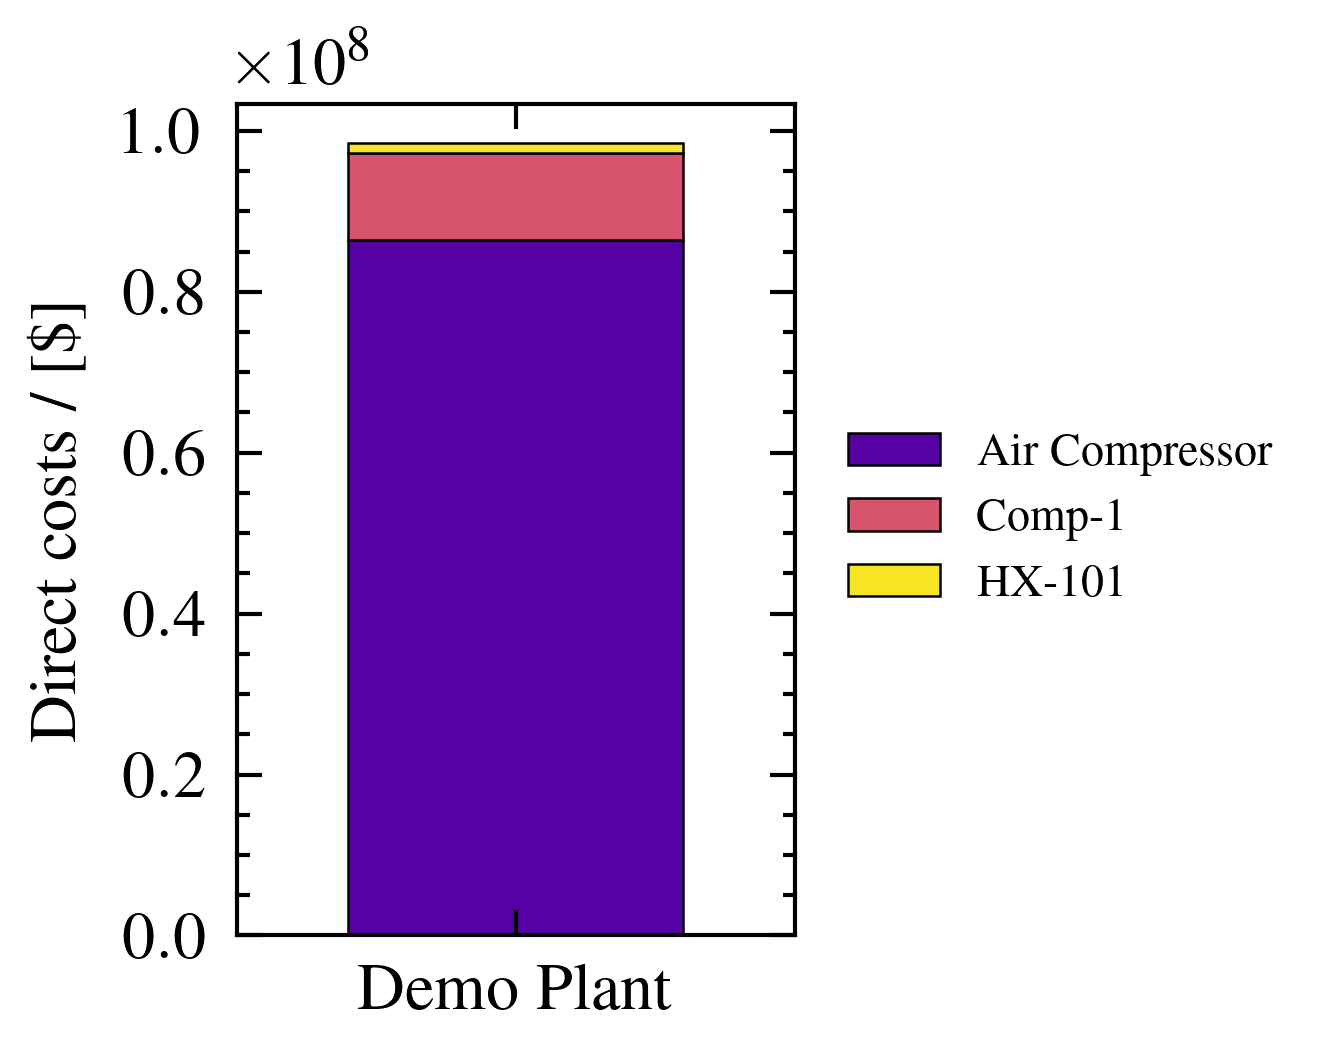

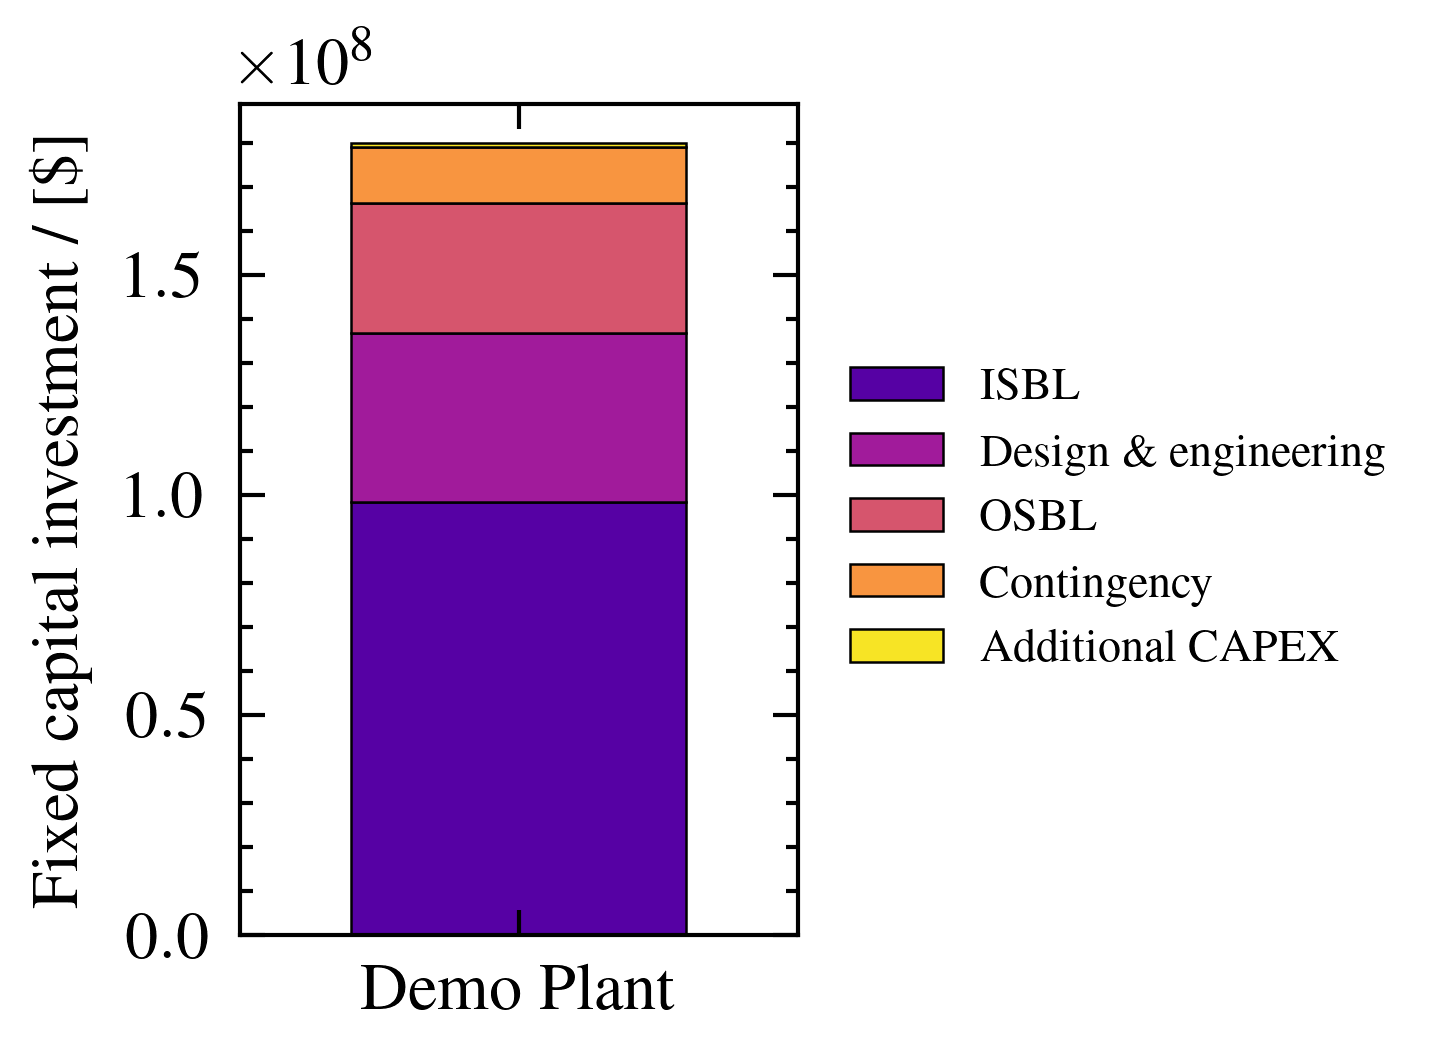

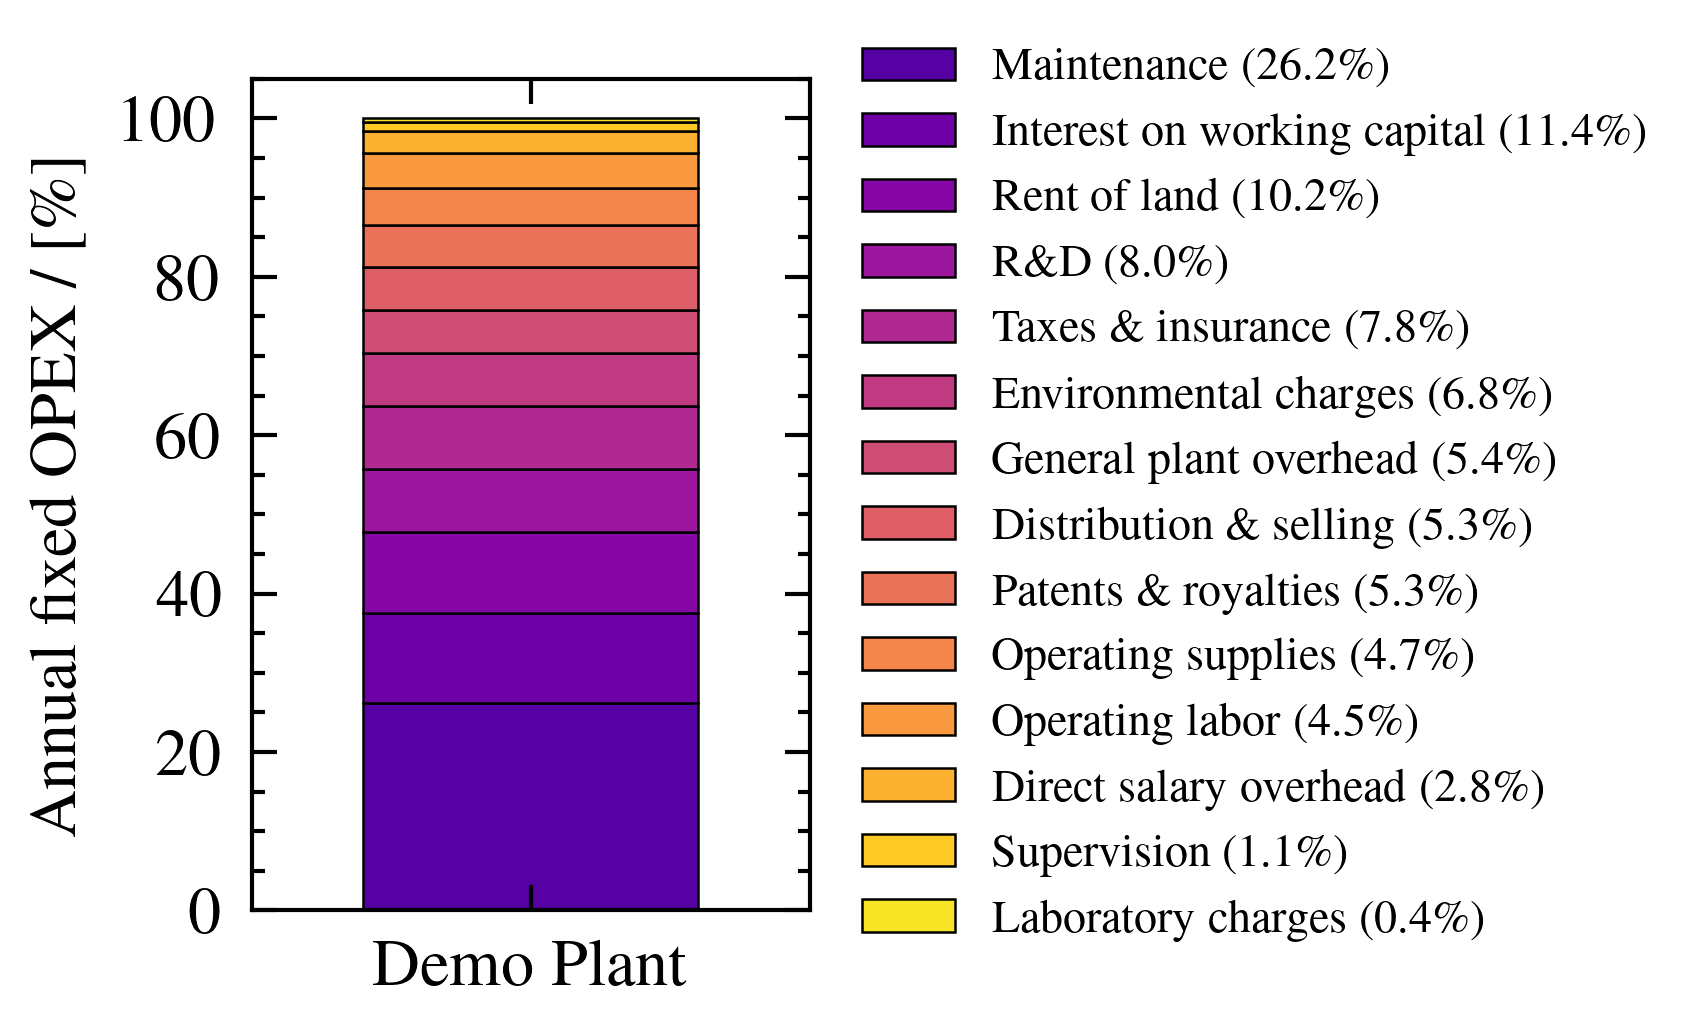

In [29]:
plot_direct_costs_bar(plants=demo_plant)
plot_fixed_capital_bar(plants=demo_plant, additional_capex=True)  # We set additional_capex=True to include additional CAPEX events in the fixed capital plot
plot_fixed_opex_bar(plants=demo_plant, pct=True)  # We set pct=True to show fixed OPEX components as percentages of total fixed OPEX

If we have multiple plants, we can plot the breakdown side-by-side for comparison:

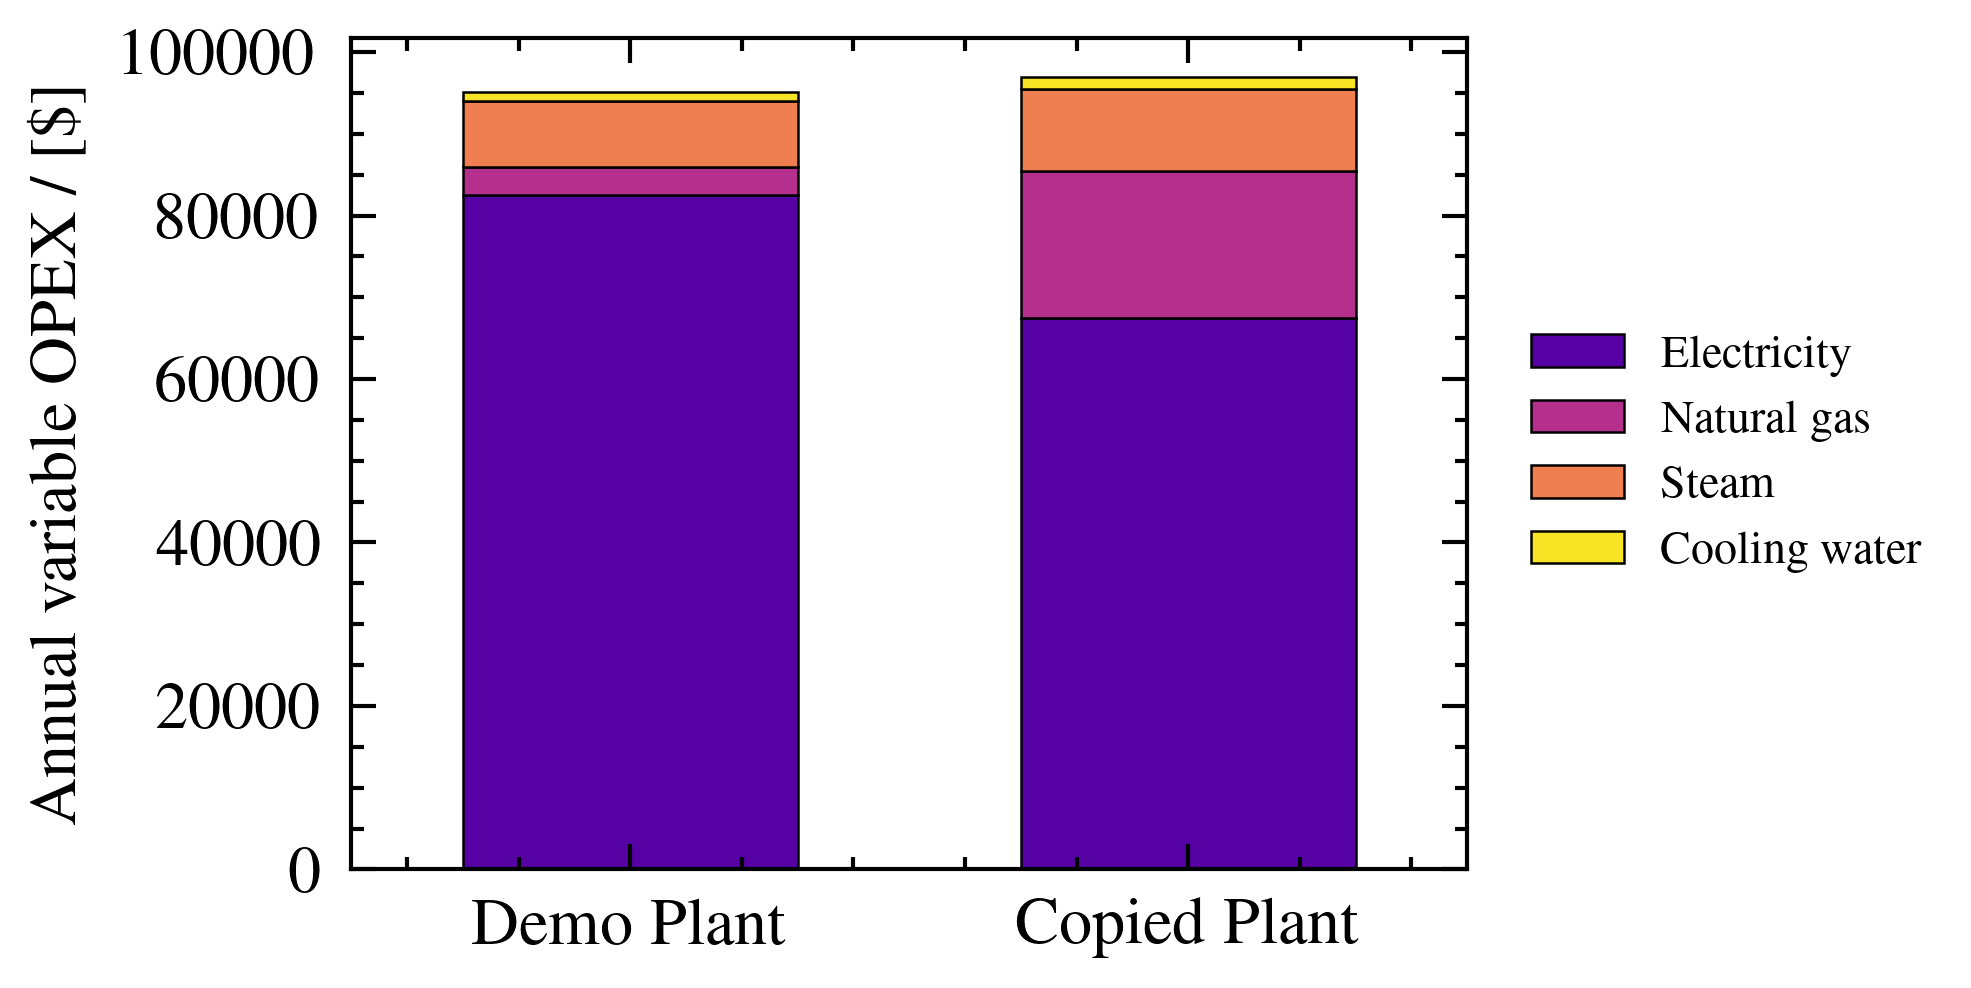

In [30]:
copy_plant = deepcopy(demo_plant)

config = {
    'plant_name': "Copied Plant",
    "variable_opex_inputs": {
        "electricity":   {"consumption": 1.35e6, "price": 0.05},
        "cooling_water": {"consumption": 2.0e6, "price": 0.0007},
        "steam":         {"consumption": 5.0e5, "price": 0.02},
        "natural_gas":   {"consumption": 1.2e6, "price": 0.015}
    },
}

copy_plant.update_configuration(config)

plot_variable_opex_bar(plants=[demo_plant,copy_plant])  # We plot the variable OPEX bar for the copied plant with updated configuration

## ⚖️ Sensitivity and Uncertainty Analyses

In techno-economic analysis (TEA), sensitivity analysis helps quantify how uncertainty in key assumptions propagates through the model to affect economic performance.
Parameters such as capital costs, utility prices, operating factors, and financial assumptions rarely remain fixed throughout a project’s life. Understanding which inputs most strongly influence the econmic performance metrics enables better risk management and investment decisions.

This section presents three complementary approaches:

### 📈 One-Way Sensitivity Line Plot

A simple one-way (deterministic) sensitivity analysis.
A single input parameter (e.g., fixed capital, interest rate, electricity, CO₂ tax) is varied over a specified range while all other assumptions are held constant.
For each value of the input, the chosen metric is recalculated and plotted on the y-axis against the input value on the x-axis. Multiple curves can be shown to compare different technologies or scenarios.
This visualization shows how strongly the outcome responds to changes in one key driver and where technologies may become more or less competitive.

If metric is not specified, you can generate a line plot of the levelized cost sensitivity on, for instance, the natural gas price as follows:

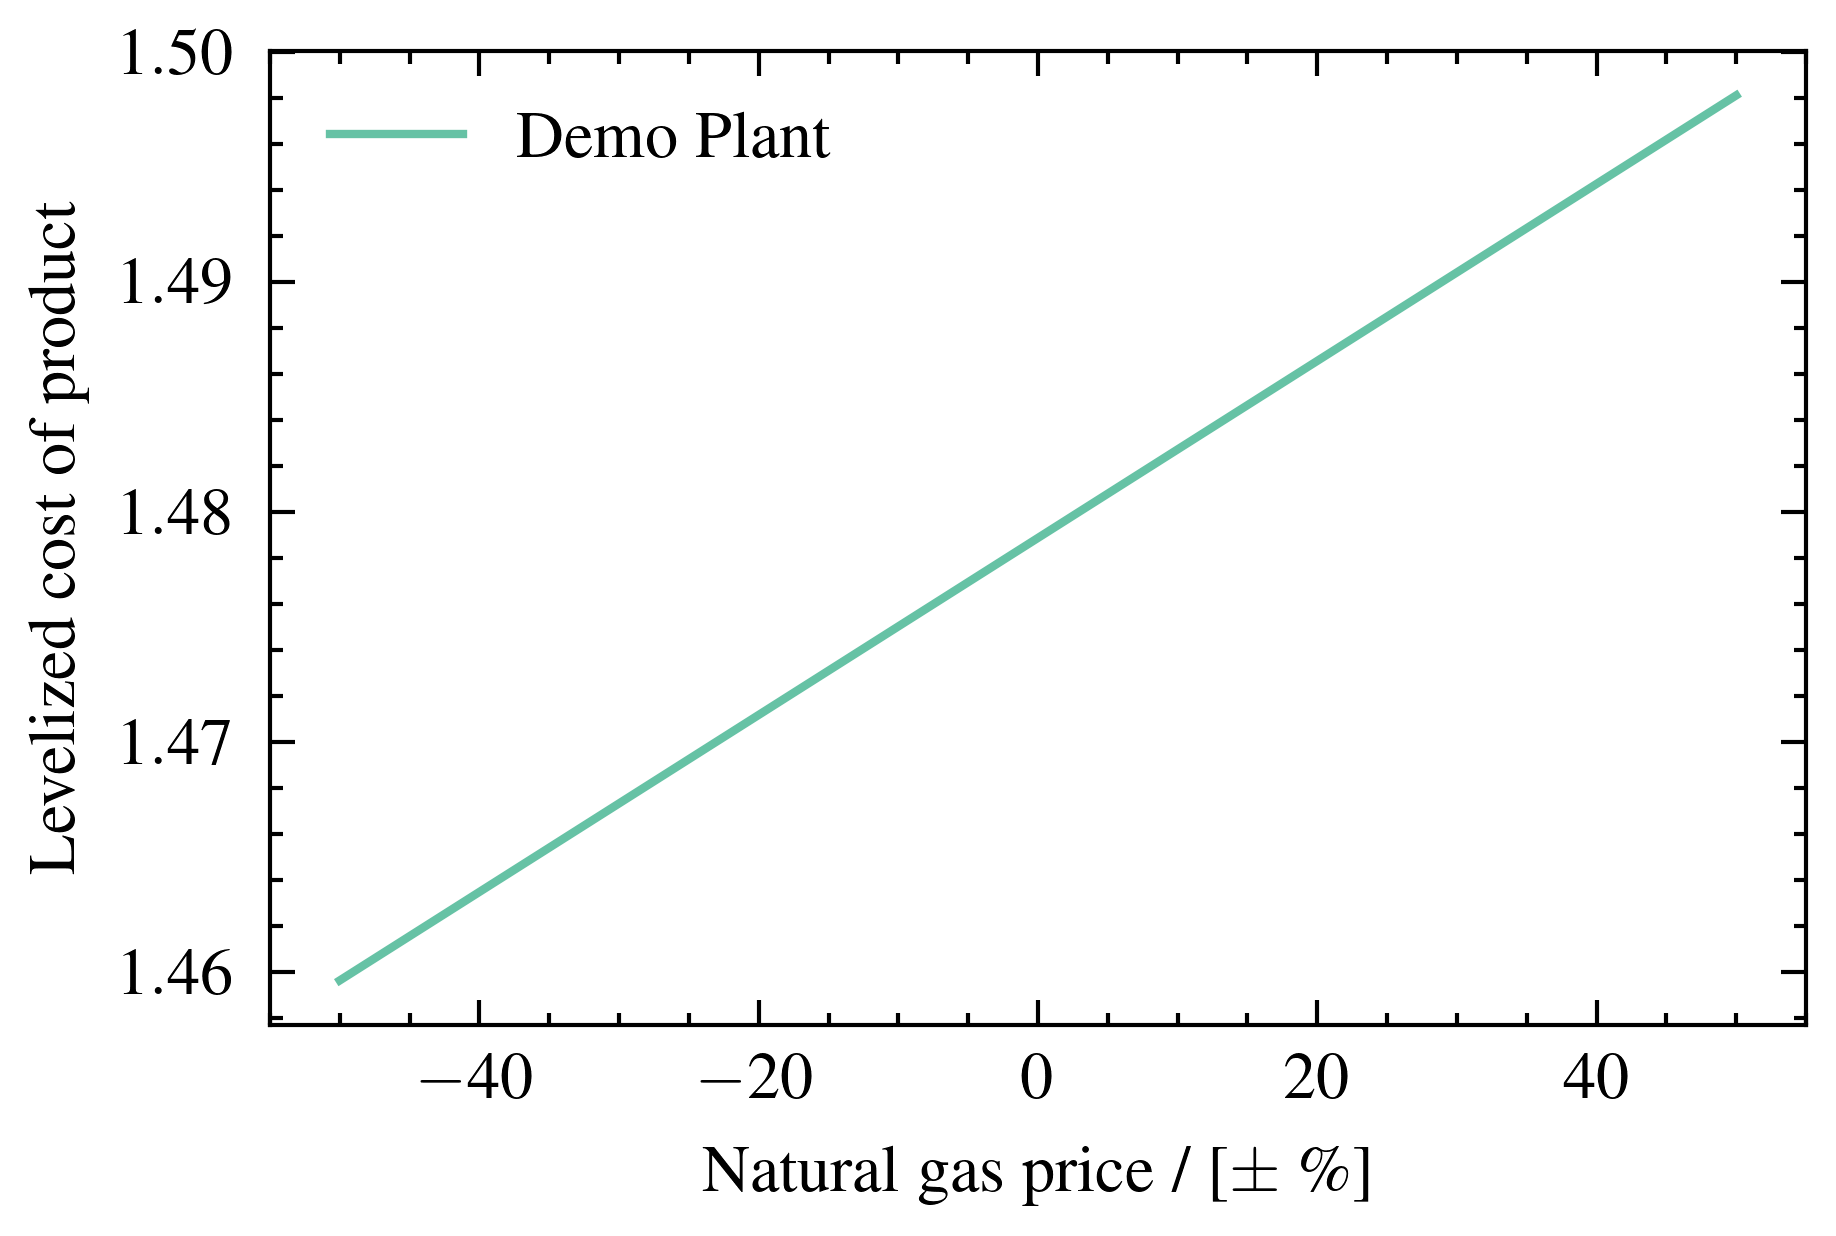

In [31]:
sensitivity_plot(plants=demo_plant, parameter="natural_gas", plus_minus_value=0.5)

Besides the `variable_opex_inputs` you can also choose to vary: 
- `fixed_capital`
- `fixed_opex`
- `project_lifetime`
- `interest_rate`
- `operator_hourly_rate`
- `plant_product.price`

You can also specify the `metric` you want to evaluate. The selections are `NPV`, `LCOP`, `PBT`, `ROI`, and `IRR`. For example:

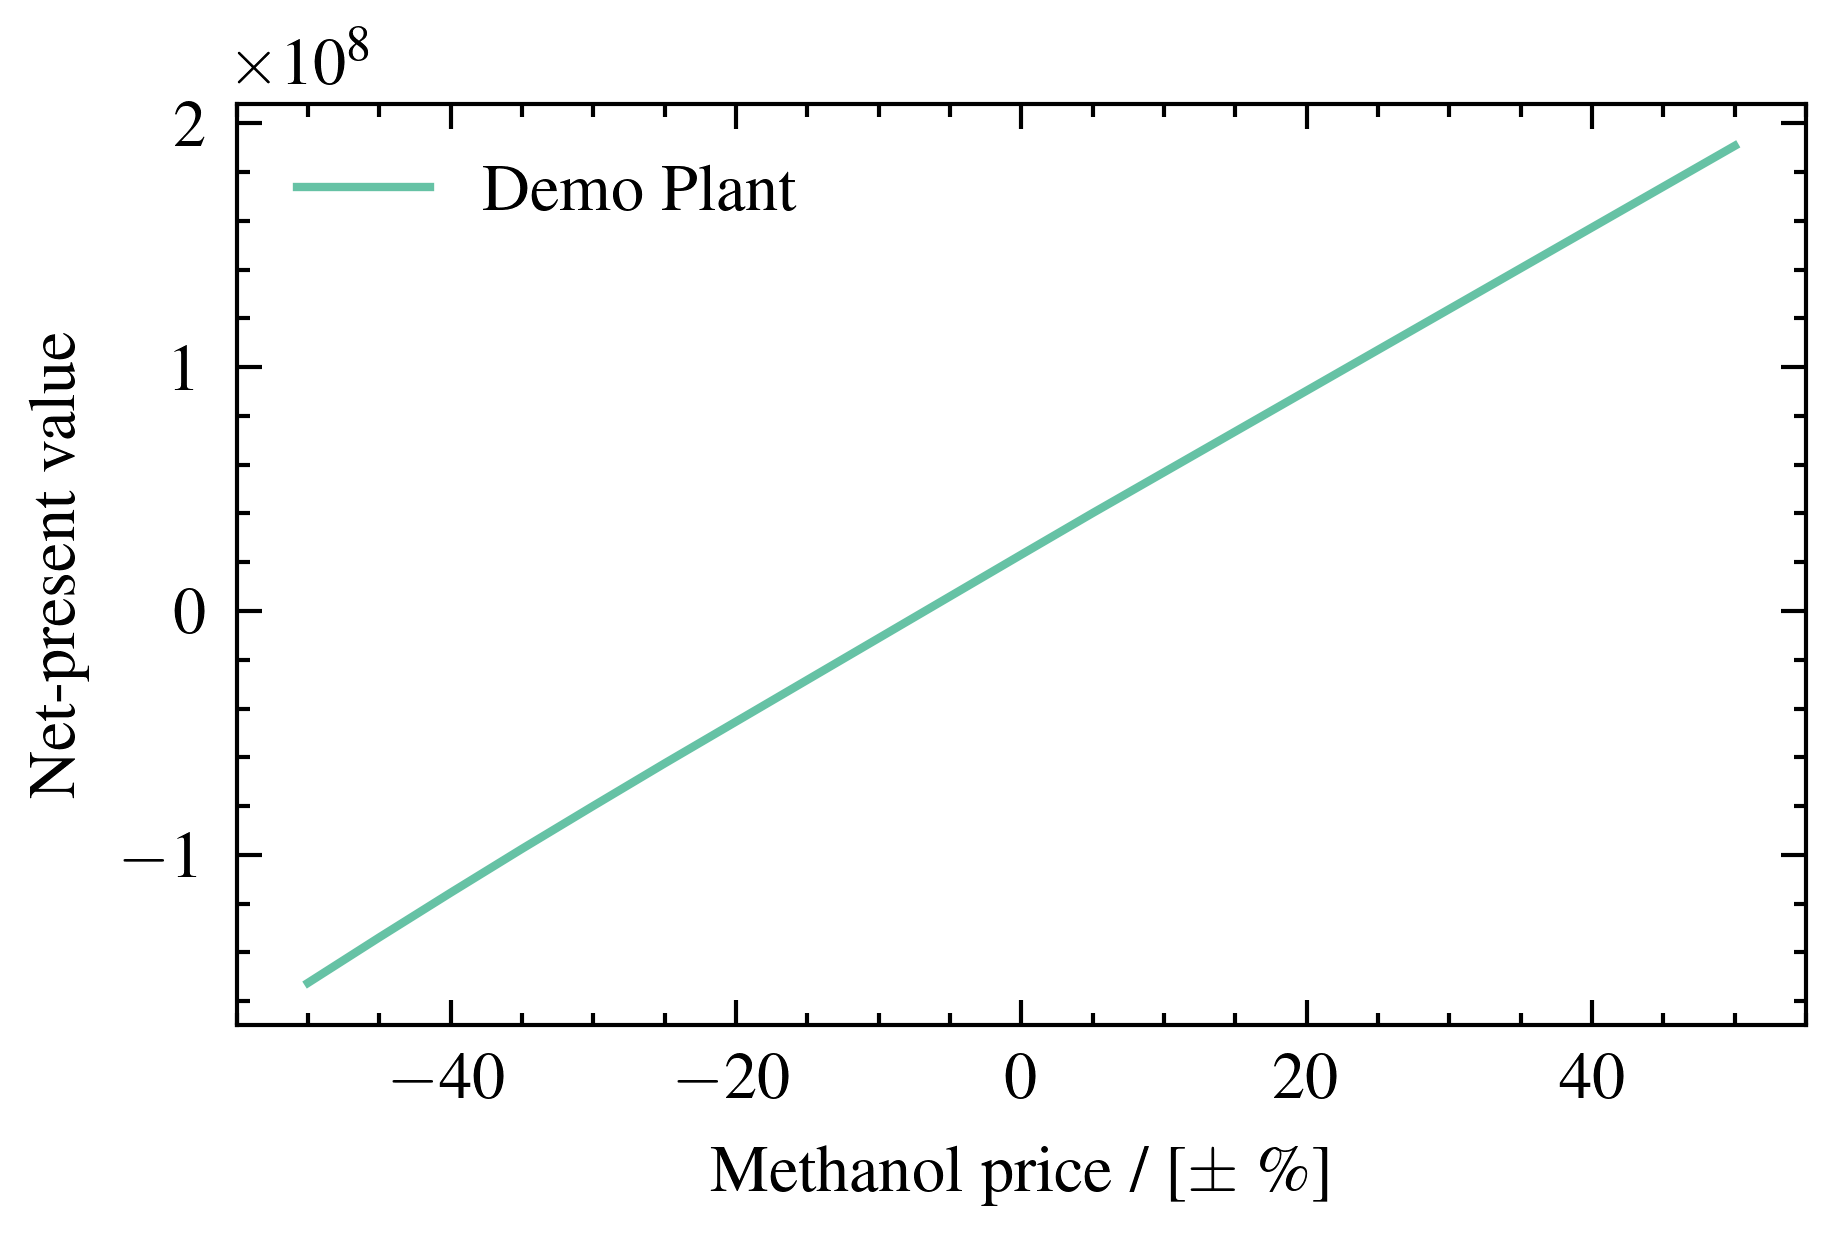

In [32]:
sensitivity_plot(plants=demo_plant, parameter="methanol", metric='NPV', plus_minus_value=0.5, label="Net-present value")  # You can change the plot label like this

If you have multiple plants, you can compare the sensitivity distribution results in one figure by making the `plants` as a list:

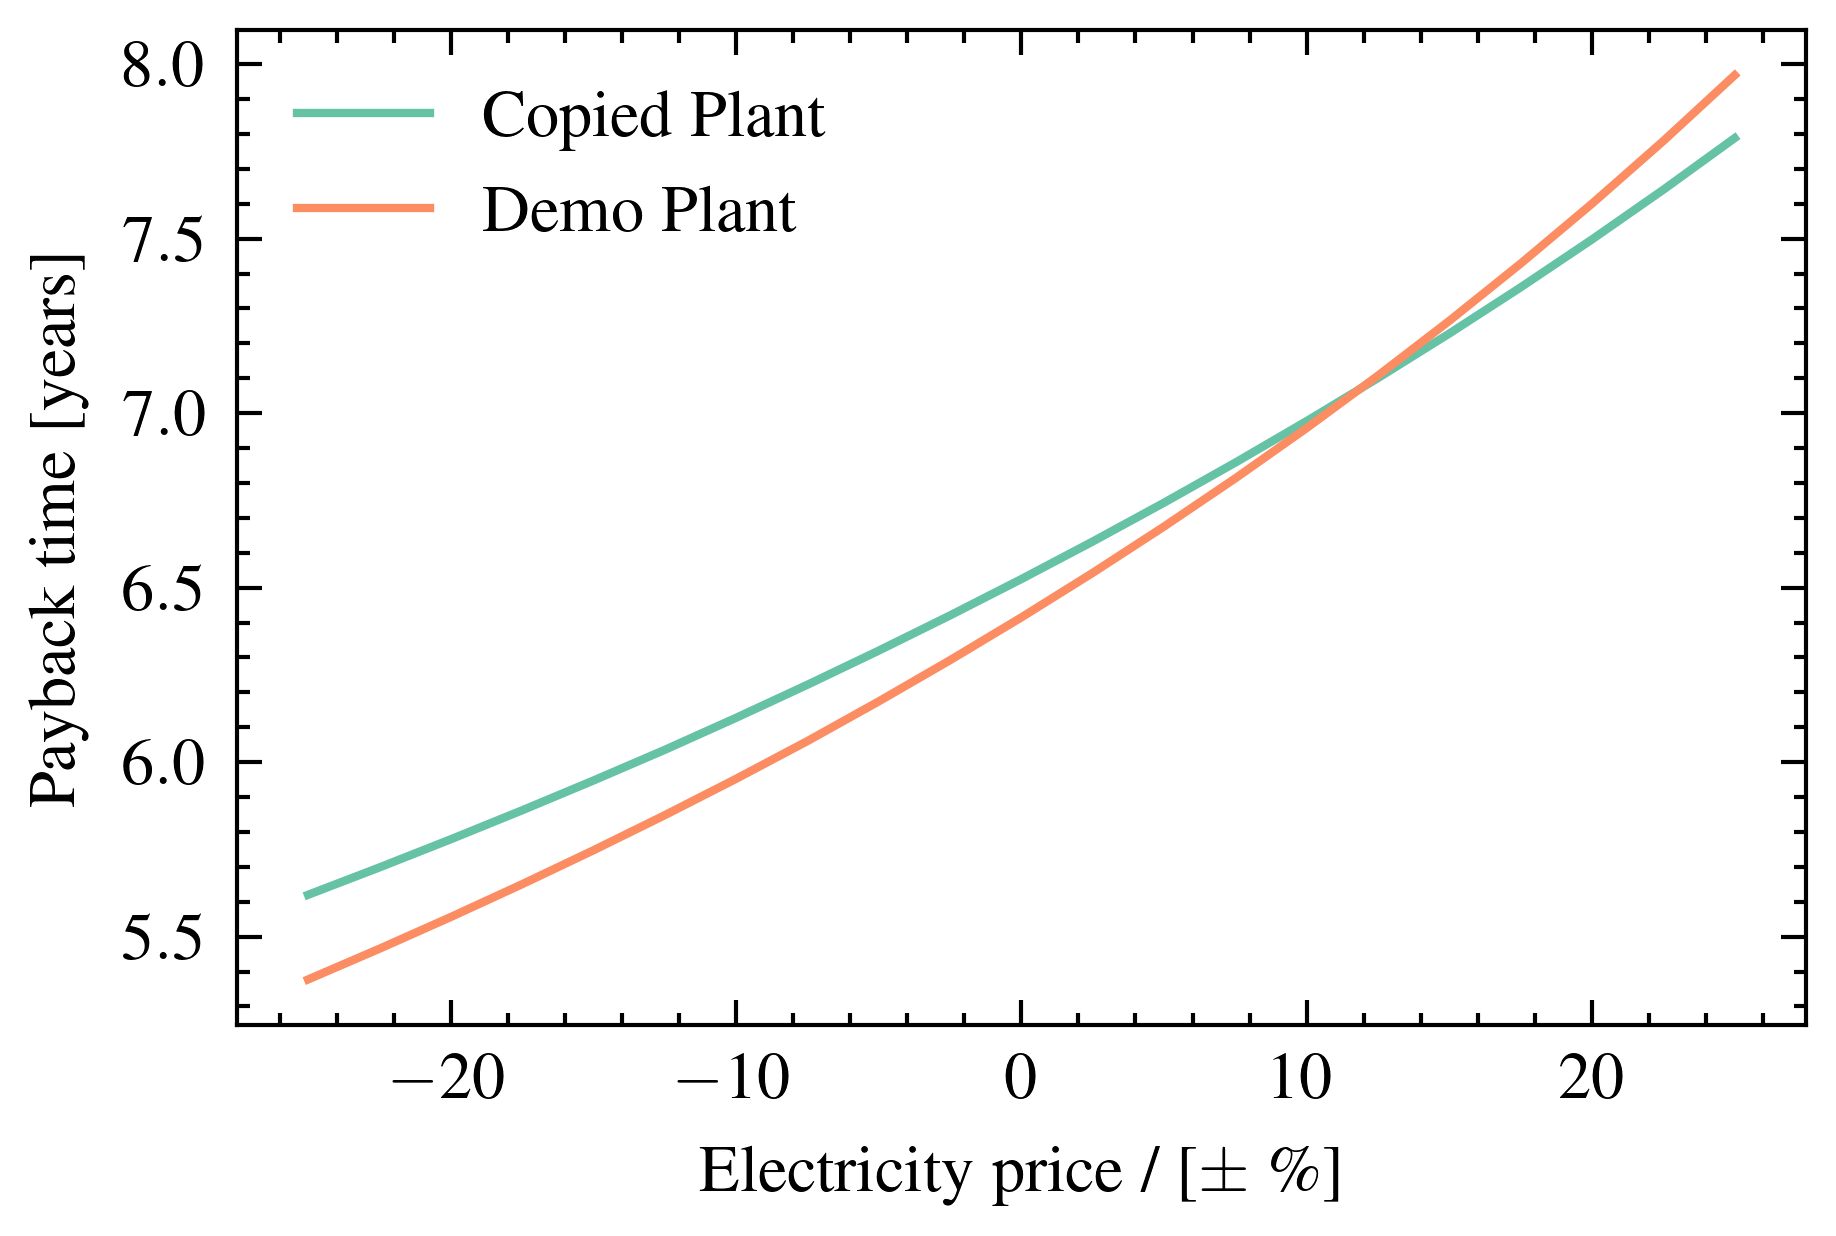

In [33]:
sensitivity_plot(plants=[copy_plant, demo_plant], parameter="electricity", metric='PBT', plus_minus_value=0.25, additional_capex=True)  
# We set additional_capex=True to account for additional CAPEX events in the PBT sensitivity

### 🌀 Tornado Plot (Deterministic Sensitivity)

A one-at-a-time (OAT) sensitivity approach.
Each selected input variable is perturbed by a fixed percentage (e.g., ±50%) around its baseline value while all other parameters remain constant.
The change in the chosen metric is recalculated for each case, and the results are displayed in a tornado plot—a horizontal bar chart where bar length indicates the magnitude of impact.
This method highlights which parameters exert the greatest influence on the project outcome and helps prioritize data refinement or cost-reduction efforts.

You generate the tornado plot as follows:

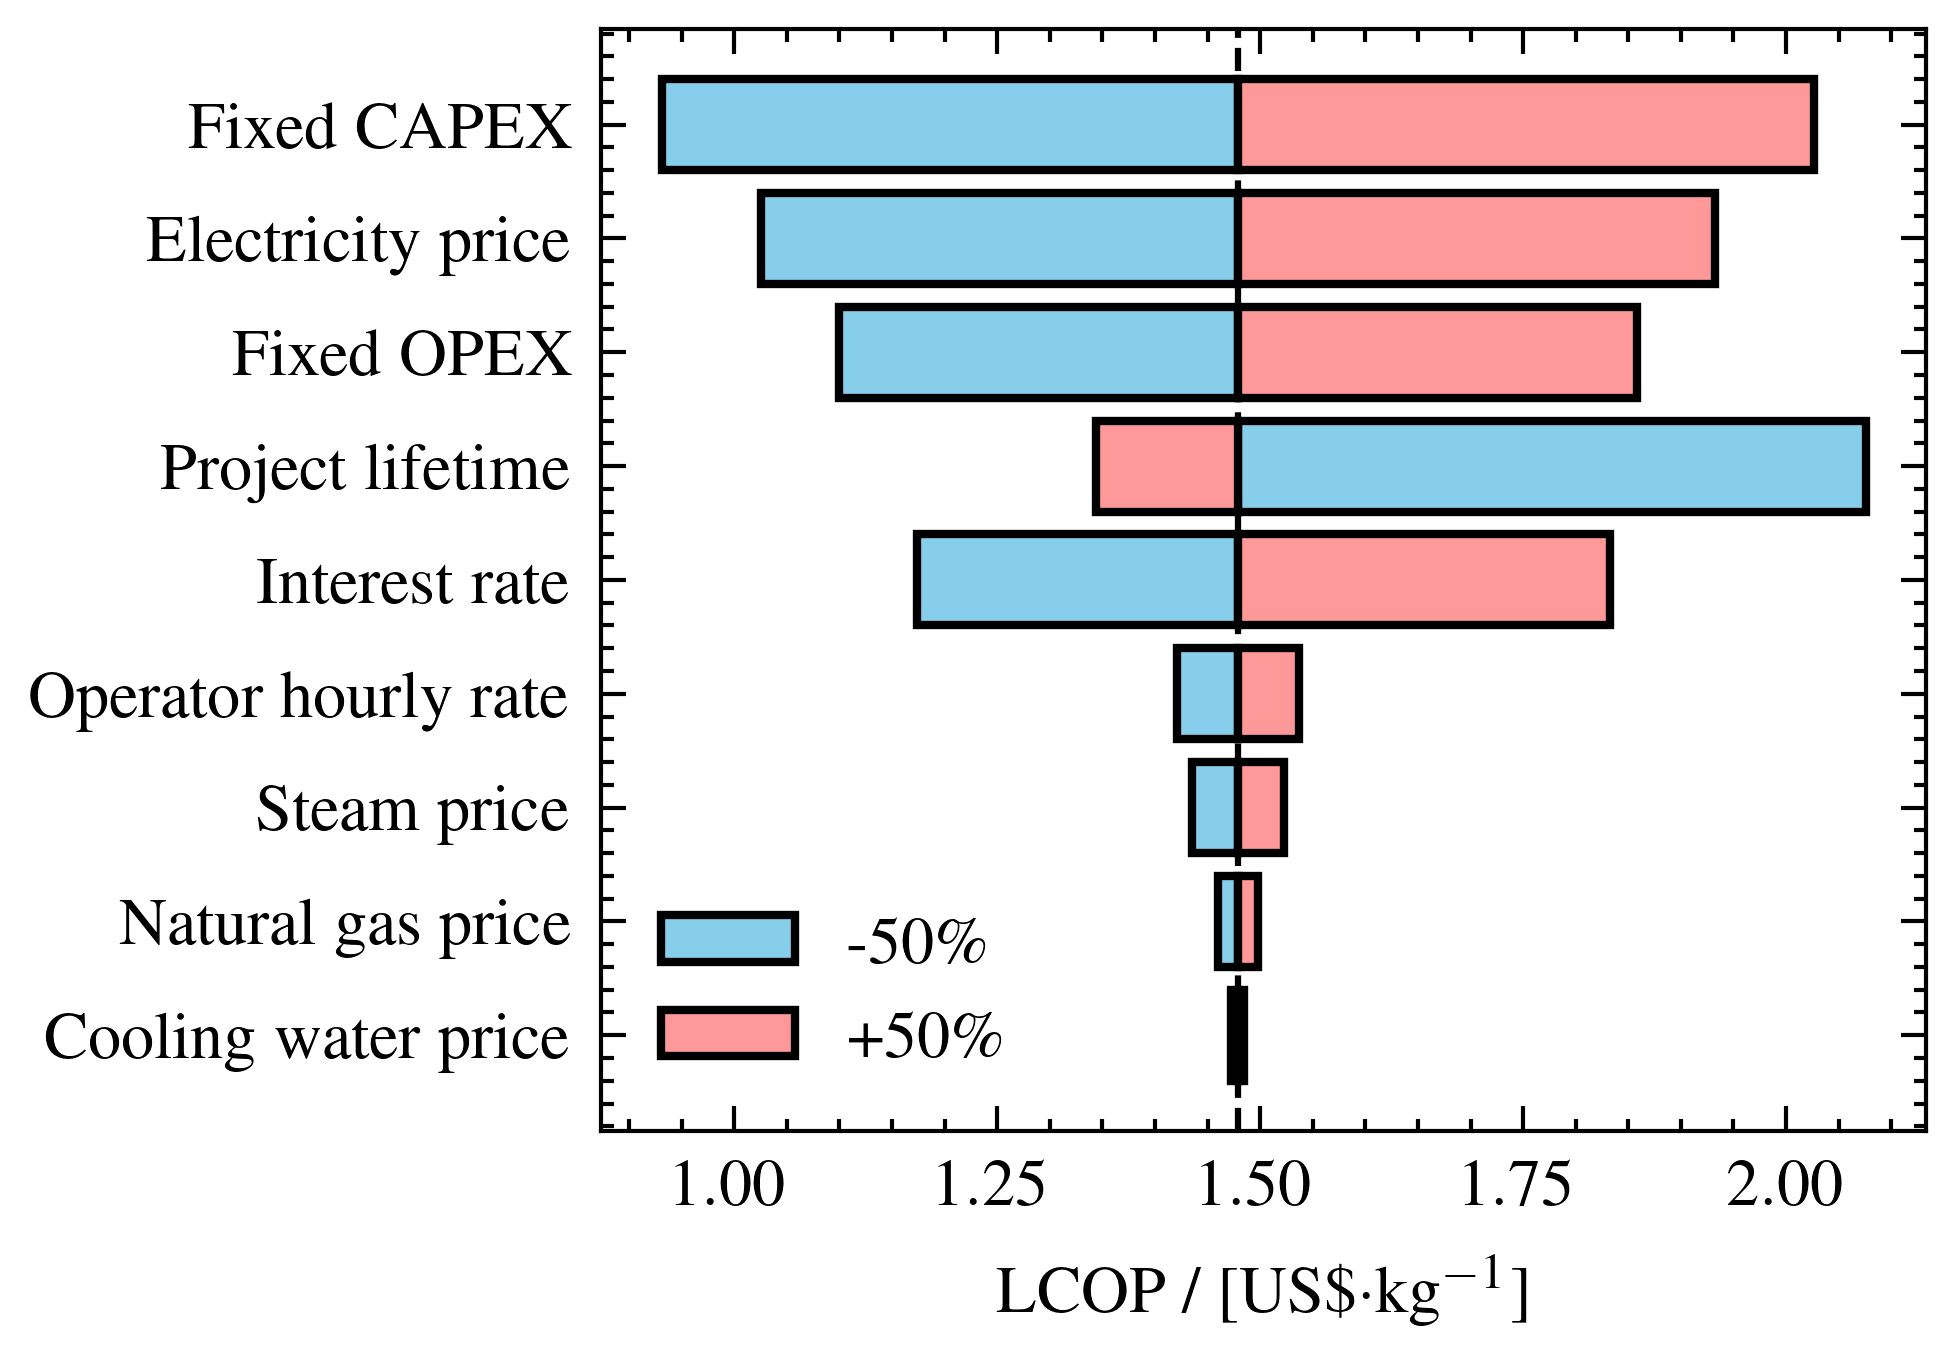

In [34]:
tornado_plot(plant = demo_plant, plus_minus_value=0.5, label=r'LCOP / [US\$$\cdot$kg$^{-1}$]')  # If metric is not chosen, LCOP is used by default

For profit-oriented metrics, the product price(s) are included in the sensitivity evaluation. For example, when evaluating ROI:

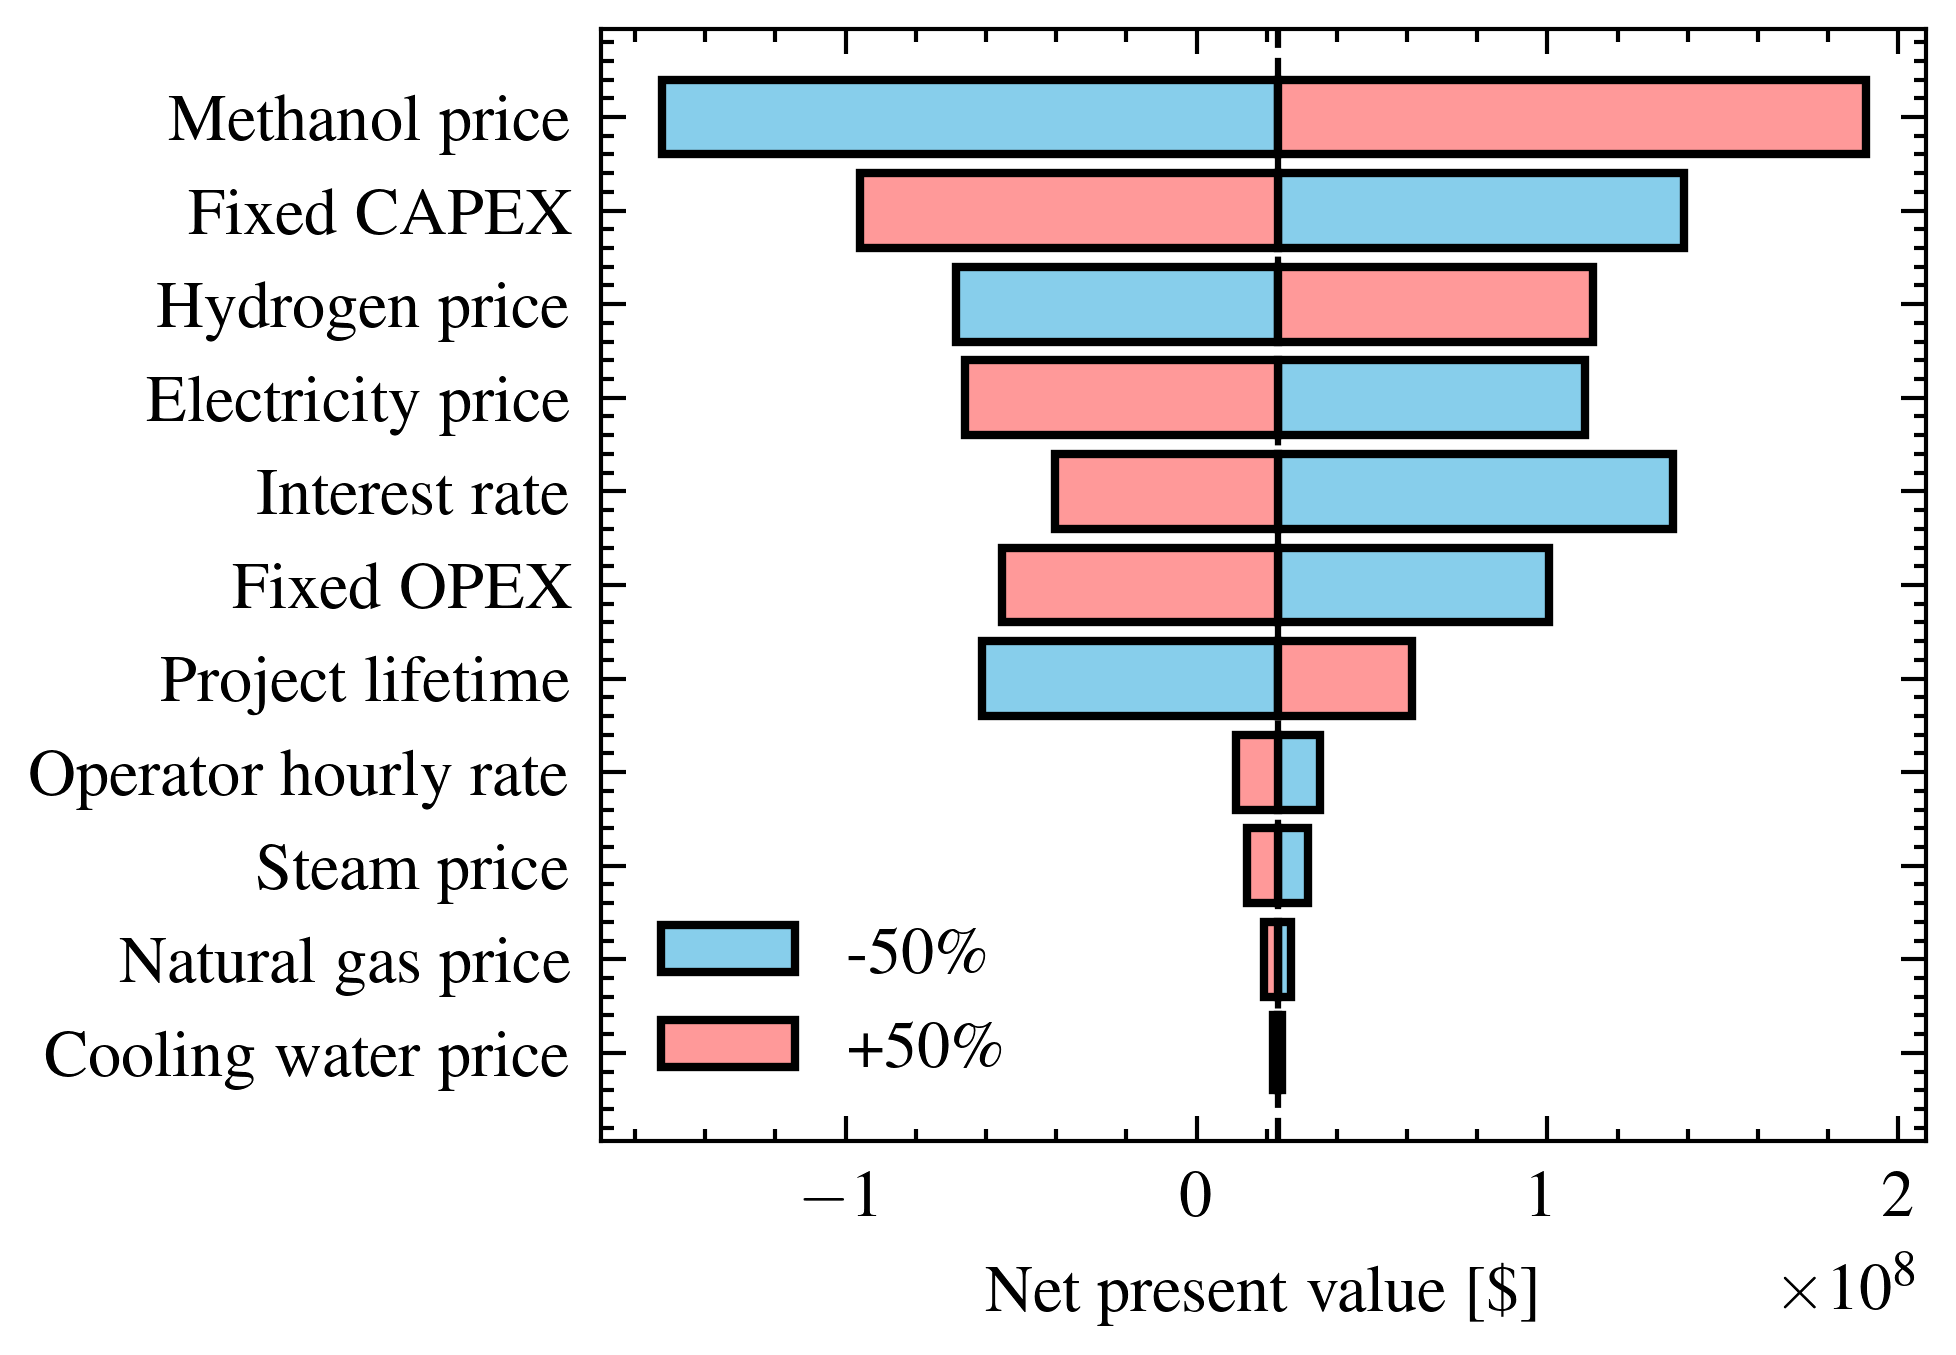

In [35]:
tornado_plot(plant = demo_plant, plus_minus_value=0.5, metric='NPV') 

### 🎲 Monte Carlo Simulation (Probabilistic Sensitivity)

A stochastic uncertainty analysis that captures simultaneous variation across all uncertain parameters.
Each variable is assigned a probability distribution (e.g., a truncated normal), and the model is executed thousands—or even millions—of times.
In every iteration, the simulation samples random values from these distributions and computes a new value for the performance metric, producing a probability distribution of outcomes.

This enables evaluation of:
- Expected values such as NPV, IRR, LCOP (mean or median),
- The spread of outcomes (variance or confidence intervals),
- The likelihood of exceeding target costs or achieving economic viability.

Monte Carlo analysis therefore provides a probabilistic view of economic risk, complementing the deterministic insight from the tornado plot.

**Defining The Products and OPEX Inputs with Uncertainty for Monte Carlo Analysis**

To perform Monte Carlo simulations, the operator hourly rate, plant product prices, and variable OPEX item prices must include not only their baseline values but also their statistical uncertainty.
Each utility or consumable input is therefore defined using:
- `consumption` or `production`– the daily usage/production quantity
- `price` – the mean or baseline unit price
- `std` – the standard deviation around the mean, representing uncertainty
- `min` / `max` – lower and upper bounds used to truncate extreme values

This structure enables the simulation engine to draw random samples for each input price from a bounded normal distribution, ensuring that every Monte Carlo iteration reflects realistic cost variability.

In [36]:
config = {
    "plant_products": {             # This does not need to be specified when evaluating for LCOP
        "methanol": {
            "production": 150_000, 
            "price": 1.75, 
            "std": 0.25,             # Standard deviation (uncertainty)
            "min": 1.25,             # Minimum plausible price
            "max": 2.25              # Maximum plausible price
        },
        "hydrogen": {
            "production": 50_000,
            "price": 1.25,
            "std": 0.1,             # Standard deviation (uncertainty)
            "min": 0.75,            # Minimum plausible price
            "max": 1.75             # Maximum plausible price
        }
    },
    "operator_hourly_rate": {
        "rate":  38.11,             # This is in $/hour
        "std": 10.0,                # Standard deviation (uncertainty)
        "min": 20.0,                # Minimum plausible rate
        "max": 60.0                 # Maximum plausible rate
    },
    "variable_opex_inputs": {
        "electricity": {
            "consumption": 1.1e6,   # Daily consumption 
            "price": 0.1,           # Mean unit price
            "std": 0.035,           # Standard deviation (uncertainty)
            "min": 0.025,           # Minimum plausible price
            "max": 0.175            # Maximum plausible price
        },
        "cooling_water": {
            "consumption": 1.6e6,  # Daily consumption
            "price": 0.0008,       # Mean unit price 
            "std": 0.0003,         # Standard deviation
            "min": 0.0001,         # Minimum plausible price
            "max": 0.0014          # Maximum plausible price
        },
        "steam": {
            "consumption": 4.0e5,  # Daily consumption 
            "price": 0.04,         # Mean unit price 
            "std": 0.02,           # Standard deviation
            "min": 0.00,           # Minimum plausible price
            "max": 0.08            # Maximum plausible price
        },
        "natural_gas": {
            "consumption": 1.0e5,  # Daily consumption 
            "price": 0.05,         # Mean unit price 
            "std": 0.03,           # Standard deviation
            "min": 0.001,          # Minimum plausible price
            "max": 0.1             # Maximum plausible price
        }
        # Add more variable OPEX items as needed
    }
}

demo_plant.update_configuration(config)

**Additional Economic Uncertainties for Monte Carlo**

Besides variable OPEX, several plant-level parameters strongly affect economic results.
These can also be randomized in simulations to capture financial uncertainty:

| **Parameter**       | **Description**                                          | **Effect on Model**                                           | **Default Standard Deviation** |
| ------------------- | -------------------------------------------------------- | ------------------------------------------------------------- | ----------------------------   |
| `fixed_capitals`    | Total installed CAPEX (ISBL + OSBL + D&E + contingency). | Drives initial investment, depreciation, and working capital. | 30%                            |  
| `fixed_opexs`       | Annual fixed OPEX (labor, maintenance, overheads).       | Affects yearly cash cost.                                     | 30%                            |
| `project_lifetimes` | Economic project life (years).                           | Defines NPV and depreciation horizon.                         | 5 years                        |
| `interests`         | Discount or financing rate (WACC).                       | Controls discounting and LCOP.                                | 3%                             |


Currently, this is not modifiable.

The following line runs the Monte Carlo analysis for LCOP evaluation with 1,000,000 millions sampling:

In [37]:
monte_carlo(
    demo_plant,
    num_samples= 2_000_000,
    batch_size= 1000,
)

Monte Carlo: 100%|██████████| 2000/2000 [05:11<00:00,  6.41it/s]


({'LCOP': array([1.34406299, 1.34406299, 1.34406299, ..., 1.35797666, 1.35797666,
         1.35797666], shape=(2000000,)),
  'ROI': array([17.71686534, 20.43331458, 33.0740612 , ..., 19.19750648,
         26.29712573, 18.31255272], shape=(2000000,)),
  'NPV': array([ 1.67284793e+08,  2.47280232e+08, -1.58736273e+08, ...,
         -1.96675744e+07,  8.56196389e+06, -8.63635528e+07],
        shape=(2000000,)),
  'PBT': array([2.85733084, 2.13380633, 9.69078692, ..., 8.22378518, 5.12290415,
         6.93366304], shape=(2000000,))},
 {'Fixed capital factor': array([0.5091516 , 0.3802258 , 1.72681428, ..., 1.43423598, 0.89343937,
         1.20923745], shape=(2000000,)),
  'Fixed opex factor': array([1.06046768, 0.63142032, 1.07172345, ..., 0.98759985, 1.66075049,
         1.28346192], shape=(2000000,)),
  'Operator hourly rate': array([46.71520765, 59.48566875, 40.87422255, ..., 37.57753347,
         33.66268492, 52.3936355 ], shape=(2000000,)),
  'Project lifetime': array([22.96561923, 19.9

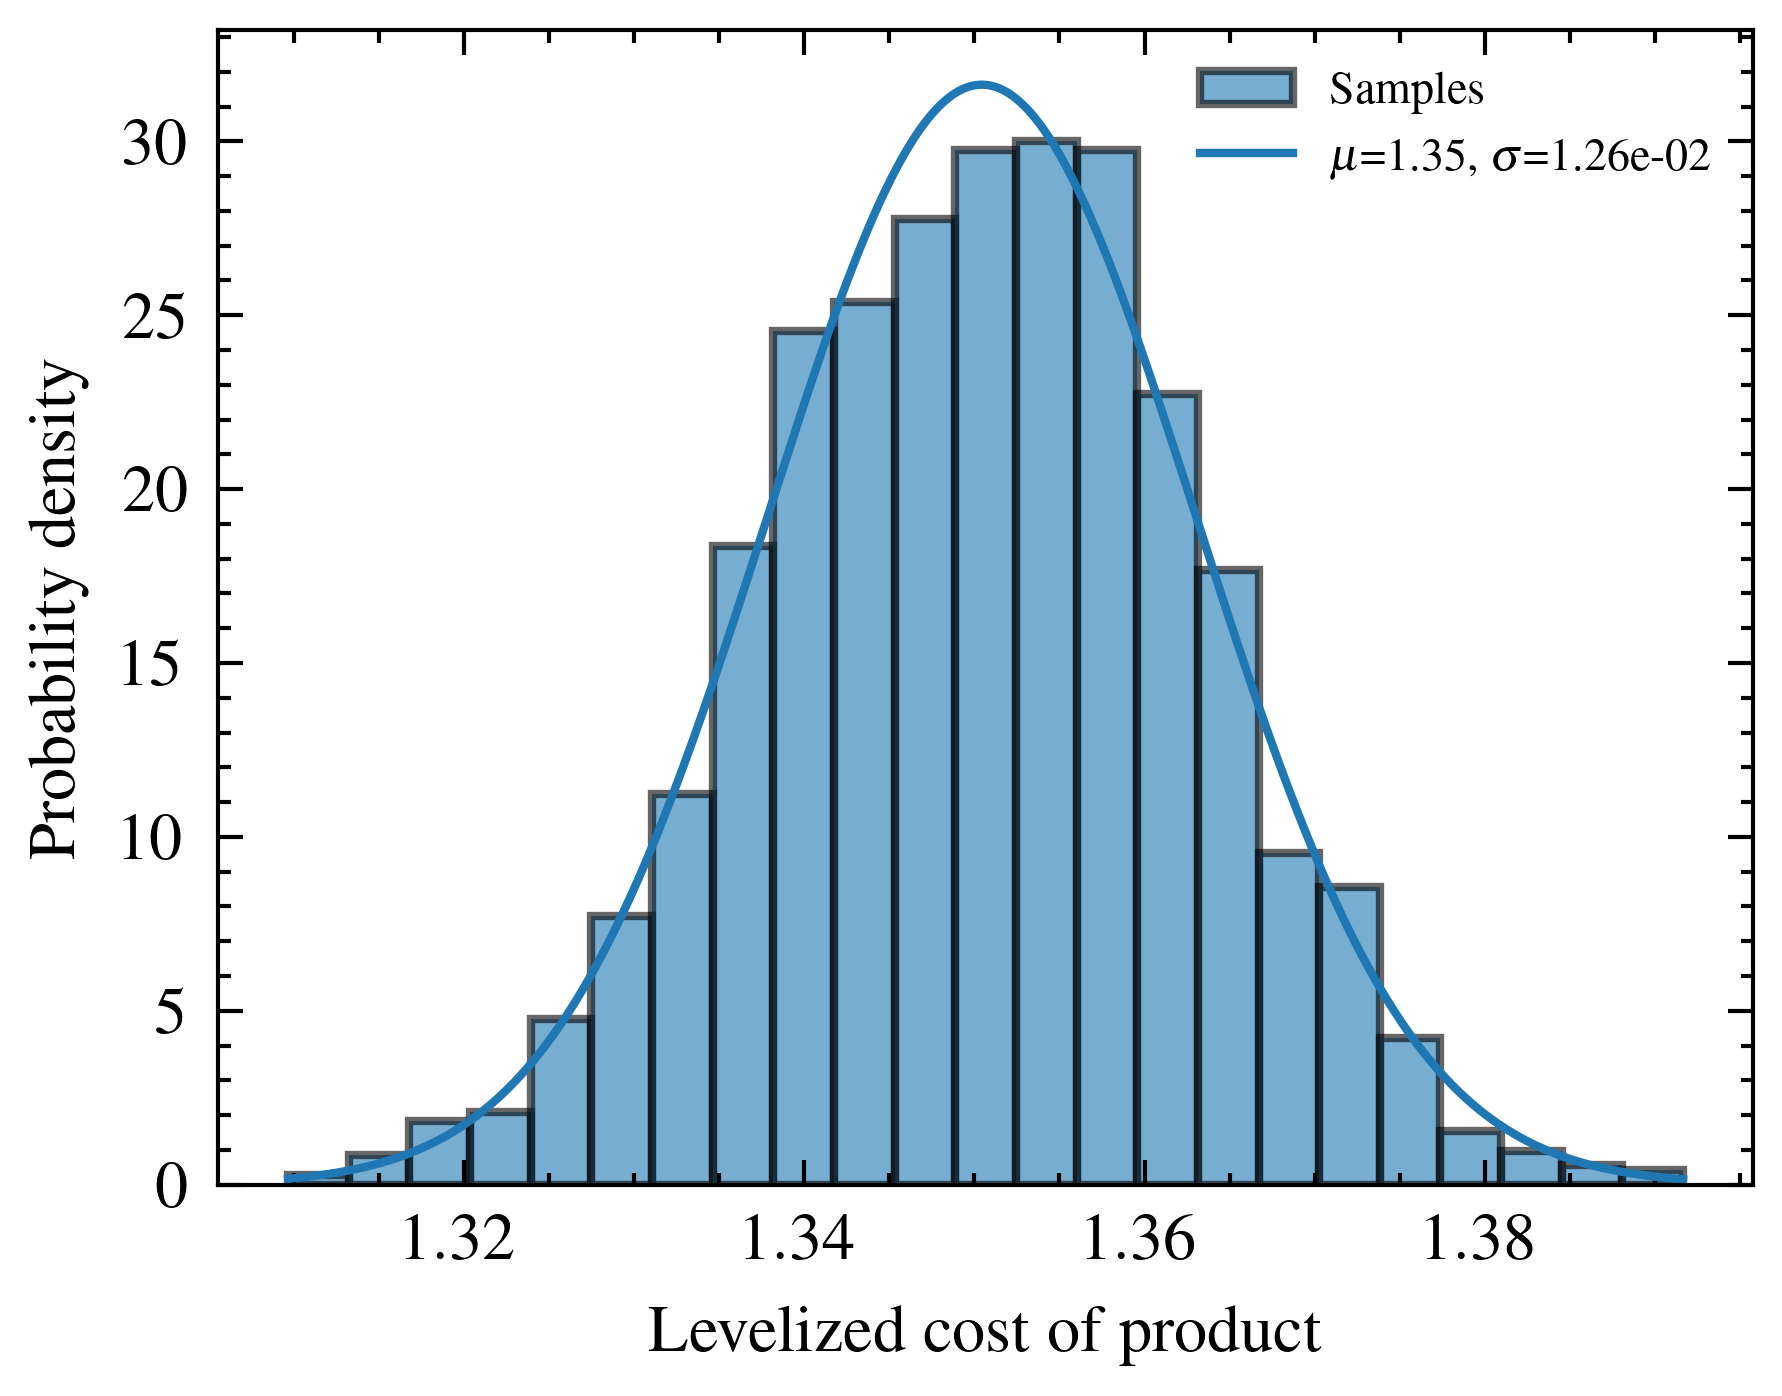

In [38]:
plot_monte_carlo(plant=demo_plant, bins=23, metric="LCOP")

Now we run Monte Carlo for the NPV evaluation:

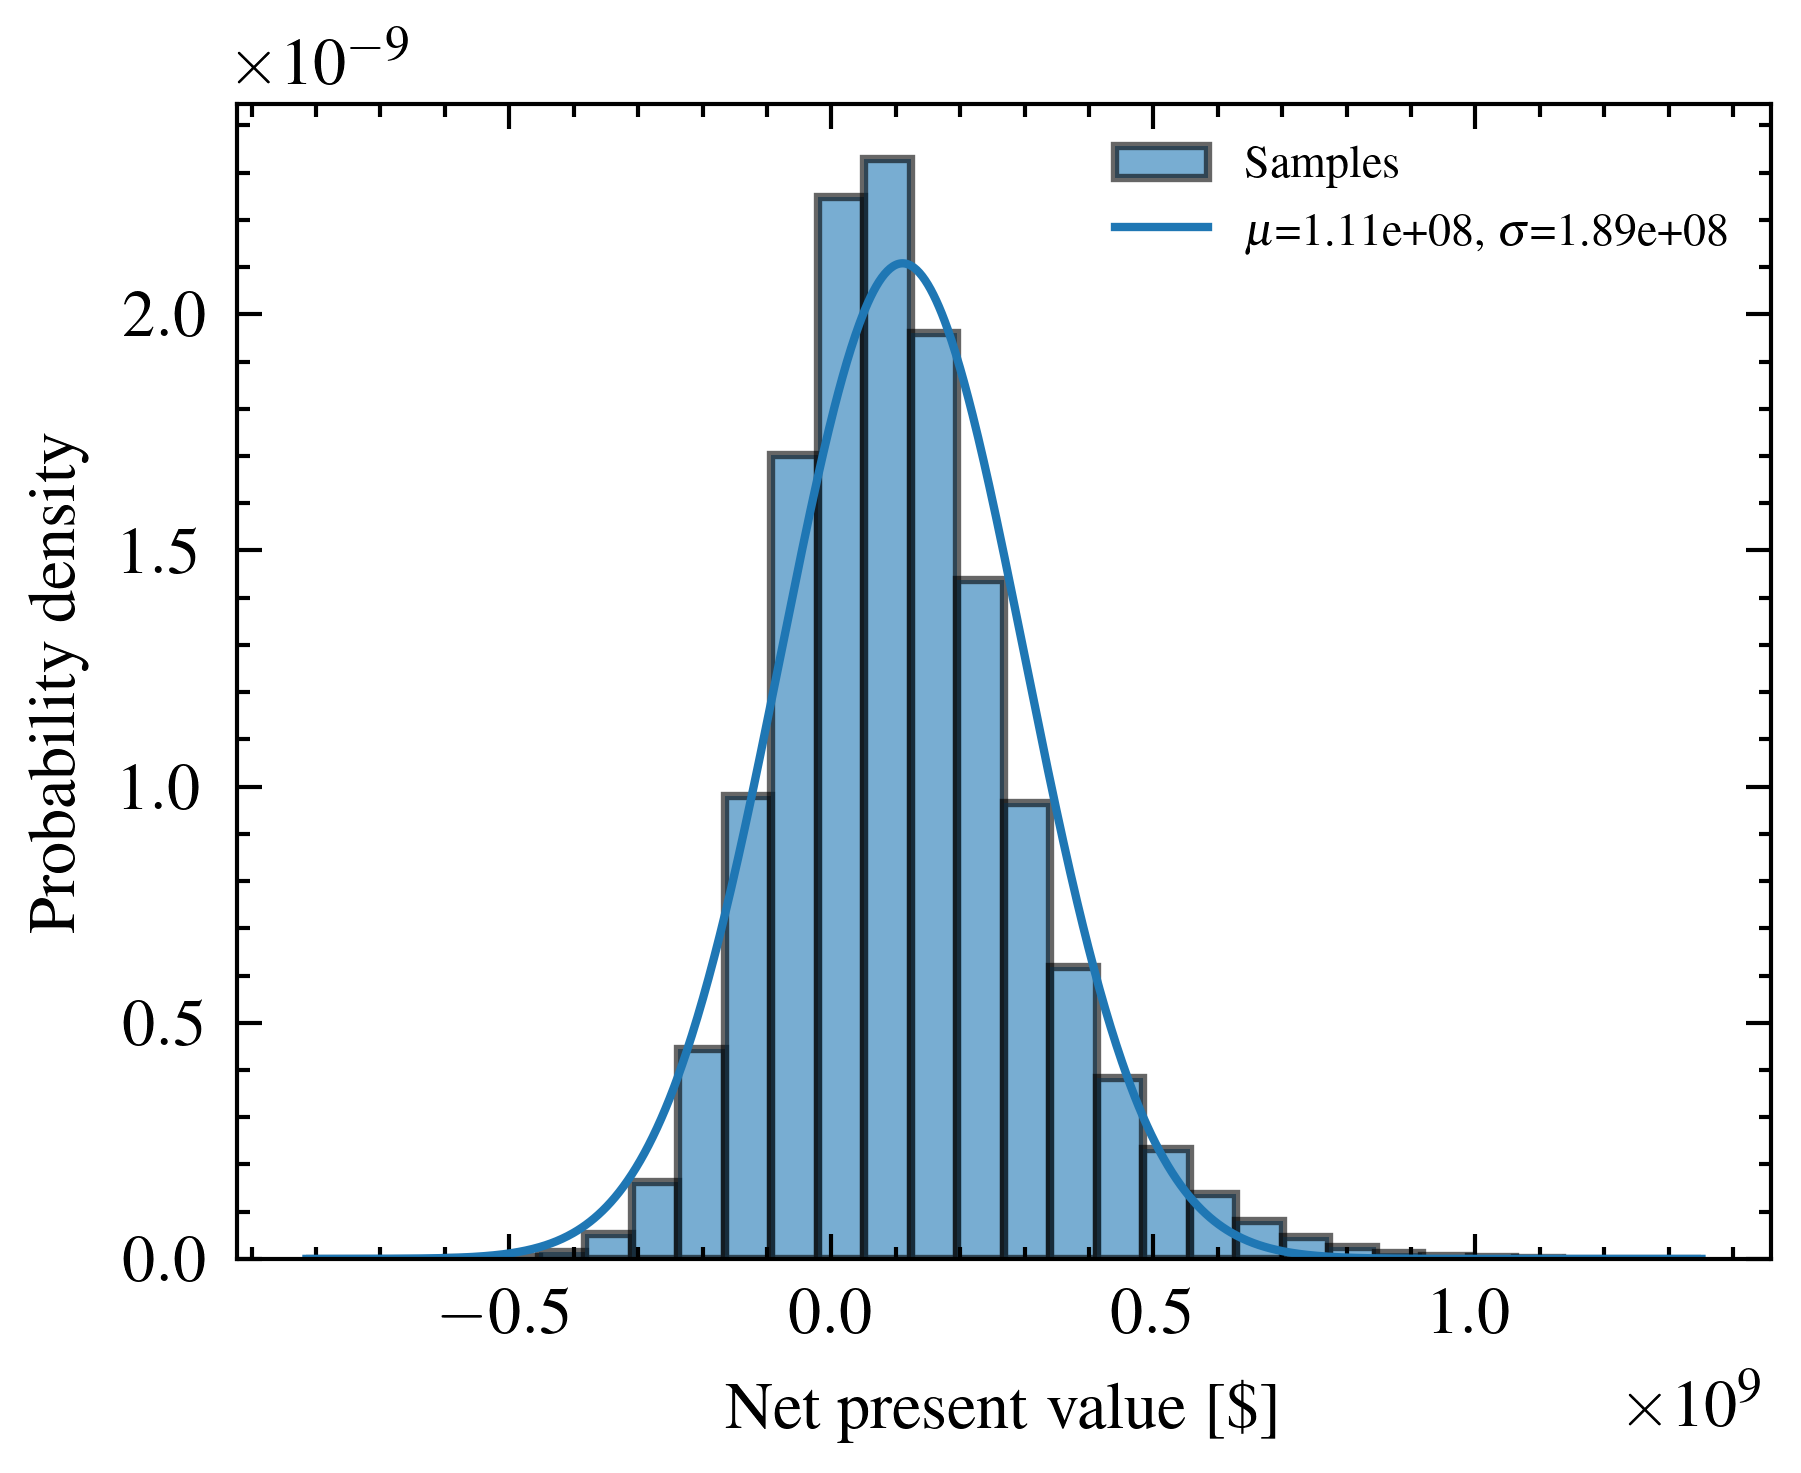

In [39]:
plot_monte_carlo(plant=demo_plant, bins=30, metric="NPV")

In [40]:
plot_monte_carlo_inputs(plant=demo_plant, bins=50)

If you have multiple plants, you can plot the probability distribution results in one figure. See `examples/case_study_1` and `examples/case_study_2`.

## Good luck!